In [ ]:
import os
from utils import *
import utils
from agents import *
import time
import torch
import torch.nn as nn
from copy import deepcopy
import argparse

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--seeds',          type=int,       default=[2023, 2024, 2025])
parser.add_argument('--dataset',        type=str,       default='cifar10')
parser.add_argument('--batch_size',     type=int,       default=512)
parser.add_argument('--model_name',     type=str,       default='allcnn')
parser.add_argument('--retrain',        type=bool,      default=False)
parser.add_argument('--unlearn_class',  type=list,      default=3)
args = parser.parse_args("")
args.time_str = time.strftime("%m-%d-%H-%M", time.localtime())
if args.dataset.lower() == 'fmnist':
    args.n_channels = 1
else:
    args.n_channels = 3

if args.dataset.lower() == 'cifar100':
    args.num_classes = 100
else:
    args.num_classes = 10
criterion = nn.CrossEntropyLoss()

In [3]:
dict = {
    1: {'unlean_class': [3], 'arxiv_name': '12-20-01-30'},
    2: {'unlean_class': [1, 3], 'arxiv_name': '12-20-08-39'},
    3: {'unlean_class': [1, 3, 5], 'arxiv_name': '12-20-09-24'},
    4: {'unlean_class': [1, 3, 5, 7], 'arxiv_name': '12-20-10-04'},
    5: {'unlean_class': [1, 2, 3, 5, 7], 'arxiv_name': '12-20-10-42'},
}
num_unlearn = 1
args.unlean_class = dict[num_unlearn]['unlean_class']
arxiv_name = dict[num_unlearn]['arxiv_name']

In [4]:
def get_unlearn_dataloader(data_loader):
    dataset = data_loader.dataset
    _indices = data_loader.sampler.indices

    if args.dataset.lower() == 'svhn':
        train_targets = np.array(dataset.targets)[_indices]
    else:
        train_targets = np.array(dataset.targets)[_indices]
    unlearn_indices, remain_indices = [], []
    for i, target in enumerate(train_targets):
        if target in args.unlearn_class:
            unlearn_indices.append(i)
        else:
            remain_indices.append(i)

    unlearn_indices = np.array(_indices)[unlearn_indices]
    remain_indices = np.array(_indices)[remain_indices]

    unlearn_sampler = torch.utils.data.SubsetRandomSampler(unlearn_indices)
    unlearn_loader = torch.utils.data.DataLoader(dataset,
                                                batch_size=args.batch_size,
                                                sampler = unlearn_sampler,)

    remain_sampler = torch.utils.data.SubsetRandomSampler(remain_indices)
    remain_loader = torch.utils.data.DataLoader(dataset,
                                                batch_size=args.batch_size,
                                                sampler = remain_sampler)
    return remain_loader, unlearn_loader

def get_dataloader(args):
    train_loader, test_loader = utils.get_dataloader(args)

    indices = np.arange(len(train_loader.dataset))
    a = np.split(indices,[int(len(indices)*0.9), int(len(indices))])
    idx_train = a[0]
    idx_val = a[1]
    train_sampler = torch.utils.data.SubsetRandomSampler(idx_train)
    val_sampler = torch.utils.data.SubsetRandomSampler(idx_val)

    train_loader = torch.utils.data.DataLoader(train_loader.dataset,
                                                batch_size=args.batch_size,
                                                sampler=train_sampler)
    
    val_loader = torch.utils.data.DataLoader(train_loader.dataset,
                                                batch_size=args.batch_size,
                                                sampler=val_sampler)
    
    test_loader = torch.utils.data.DataLoader(test_loader.dataset,
                                            batch_size=args.batch_size,
                                            shuffle=False)
    
    if args.retrain:
        train_loader, _ = get_unlearn_dataloader(train_loader)
        val_loader, _ = get_unlearn_dataloader(val_loader)
        
    return train_loader, val_loader, test_loader

In [5]:
train_loader, val_loader, test_loader = get_dataloader(args)
remain_train_loader, unlearn_train_loader = split_2_remain_unlearn(args, train_loader)
remain_val_loader, unlearn_val_loader = split_2_remain_unlearn(args, val_loader)
remain_test_loader, unlearn_test_loader = split_2_remain_unlearn(args, test_loader)

remain_class = np.setdiff1d(np.arange(args.num_classes), args.unlearn_class)

Files already downloaded and verified
Files already downloaded and verified


# unlearn 1 class

In [6]:
arxiv_name = dict[1]['arxiv_name']
args.unlearn_class = dict[1]['unlean_class']
Acc_r, Acc_f = np.zeros((2,3)), np.zeros((2,3))
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/original_model_12-20-02-15_{args.seeds[i]}.pth'))
    Acc_f[0][i], Acc_r[0][i] = test_by_class(model, test_loader, i=args.unlearn_class)

print('------------ Retrained model ------------')
for i in range(3):
    model_r = get_model(args)
    try:
        model_r.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/retrain_model_{arxiv_name}_{args.seeds[i]}.pth'))
        Acc_f[1][i], Acc_r[1][i] = test_by_class(model_r, test_loader, i=args.unlearn_class)
    except:
        print('No retrained model')
        break

print(f'Original model Acc_f: {100*Acc_f[0].mean():.2f} \pm {100*Acc_f[0].std():.2f}')
print(f'Original model Acc_r: {100*Acc_r[0].mean():.2f} \pm {100*Acc_r[0].std():.2f}')

print(f'Retrained model Acc_f: {100*Acc_f[1].mean():.2f} \pm {100*Acc_f[1].std():.2f}')
print(f'Retrained model Acc_r: {100*Acc_r[1].mean():.2f} \pm {100*Acc_r[1].std():.2f}')

arxiv_name = 'original_model_12-20-02-15'

0.9460, 0.9610, 0.8810, [0.7980], 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.7980, Acc_r: 0.9177
0.9250, 0.9540, 0.8760, [0.8210], 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420, Acc_f: 0.8210, Acc_r: 0.9206
0.9270, 0.9530, 0.8860, [0.7790], 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470, Acc_f: 0.7790, Acc_r: 0.9247
------------ Retrained model ------------
0.9250, 0.9590, 0.9040, [0.0000], 0.9260, 0.9290, 0.9540, 0.9150, 0.9560, 0.9440, Acc_f: 0.0000, Acc_r: 0.9347
0.8840, 0.9520, 0.9150, [0.0000], 0.9070, 0.9310, 0.9450, 0.9370, 0.9640, 0.9400, Acc_f: 0.0000, Acc_r: 0.9306
0.9390, 0.9600, 0.8580, [0.0000], 0.9330, 0.9210, 0.9630, 0.9280, 0.9540, 0.9260, Acc_f: 0.0000, Acc_r: 0.9313
Original model Acc_f: 79.93 \pm 1.72
Original model Acc_r: 92.10 \pm 0.29
Retrained model Acc_f: 0.00 \pm 0.00
Retrained model Acc_r: 93.22 \pm 0.18


In [7]:
args.unlearn_class = dict[1]['unlean_class']

train_loader, val_loader, test_loader = get_dataloader(args)
train_targets_list = np.array(train_loader.dataset.targets)[train_loader.sampler.indices]
unlearn_indices = np.where(np.isin(train_targets_list, args.unlearn_class))[0]

# conver to the original indices
unlearn_indices = train_loader.sampler.indices[unlearn_indices]

unlearn_sampler = torch.utils.data.SubsetRandomSampler(unlearn_indices)
unlearn_subset_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                                    batch_size=args.batch_size, 
                                                    sampler=unlearn_sampler)
remain_class = np.setdiff1d(np.arange(args.num_classes), args.unlearn_class)

remain_indices = np.where(~np.isin(train_targets_list, args.unlearn_class))[0]
remain_indices = train_loader.sampler.indices[remain_indices]

remain_sampler = torch.utils.data.SubsetRandomSampler(remain_indices)
remain_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                            batch_size=args.batch_size, 
                                            sampler=remain_sampler)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
Proj_mat_lst =[]
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    print(f'------------ Trail {i} ------------')
    merged_feat_mat = []
    for cls_id in range(10): 
        cls_indices = np.where(np.isin(train_targets_list, cls_id))[0]
        cls_indices = train_loader.sampler.indices[cls_indices]
        cls_sampler = torch.utils.data.SubsetRandomSampler(cls_indices)
        cls_loader_dict = torch.utils.data.DataLoader(train_loader.dataset, 
                                                                batch_size=args.batch_size, 
                                                                sampler=cls_sampler)
        if cls_id in args.unlearn_class:
            continue
        for batch, (x, y) in enumerate(cls_loader_dict ):
            x = x.cuda()
            y = y.cuda()
            mat_list = get_representation_matrix(model, 
                                                x, 
                                                batch_list=[24, 100, 100, 125, 125, 250, 250, 256, 256])
            break
        threshold = 0.97 + 0.003*cls_id
        merged_feat_mat = update_GPM(mat_list, threshold, merged_feat_mat)
        proj_mat = [torch.Tensor(np.dot(layer_basis, layer_basis.transpose())) for layer_basis in merged_feat_mat]
        Proj_mat_lst.append(proj_mat)

------------ Trail 0 ------------
Threshold:  0.97
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 5/27
Layer 2 : 46/432
Layer 3 : 177/432
Layer 4 : 542/864
Layer 5 : 609/864
Layer 6 : 613/864
Layer 7 : 665/864
Layer 8 : 75/96
Layer 9 : 4/96
----------------------------------------
Threshold:  0.973
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 7/27
Layer 2 : 64/432
Layer 3 : 217/432
Layer 4 : 644/864
Layer 5 : 685/864
Layer 6 : 666/864
Layer 7 : 733/864
Layer 8 : 79/96
Layer 9 : 6/96
----------------------------------------
Threshold:  0.976
Skip Updating GPM for layer: 1
Skip Updating GPM for layer: 2
Skip Updating GPM for layer: 3
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 7/27
Layer 2 : 64/432
Layer 3 : 217/432
Layer 4 : 659/864
Layer 5 : 699/864
Layer 6 : 682

In [10]:
def get_pseudo_label(args, model, x):
    masked_output = model(x)
    masked_output[:, args.unlearn_class] = -np.inf
    pseudo_labels = torch.topk(masked_output, k=1, dim=1).indices
    return pseudo_labels.reshape(-1)

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.04)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    model.eval()
    for ep in range(25):
        for batch, (x, y) in enumerate(unlearn_subset_loader):
            x = x.cuda()
            y = get_pseudo_label(args, model, x)
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            kk = 0 
            for k, (m,params) in enumerate(sgd_mr_model.named_parameters()):
                if len(params.size())!=1:
                    sz =  params.grad.data.size(0)
                    params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                            Proj_mat_lst[i][kk].cuda()).view(params.size())
                    kk +=1
                elif len(params.size())==1:
                    params.grad.data.fill_(0)
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

0.9460, 0.9610, 0.8810, [0.7980], 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.7980, Acc_r: 0.9177
[train] epoch 0, batch 8, loss 1.020639419555664
0.9410, 0.9590, 0.8760, [0.1940], 0.9010, 0.9270, 0.9660, 0.8980, 0.9440, 0.9120, Acc_f: 0.1940, Acc_r: 0.9249
[train] epoch 1, batch 8, loss 0.6910638809204102
0.9410, 0.9580, 0.8800, [0.0970], 0.9060, 0.9190, 0.9690, 0.8980, 0.9430, 0.9120, Acc_f: 0.0970, Acc_r: 0.9251
[train] epoch 2, batch 8, loss 0.6241469979286194
0.9400, 0.9550, 0.8860, [0.0620], 0.9080, 0.9180, 0.9670, 0.8950, 0.9430, 0.9100, Acc_f: 0.0620, Acc_r: 0.9247
[train] epoch 3, batch 8, loss 0.5104382038116455
0.9410, 0.9550, 0.8840, [0.0440], 0.9130, 0.9170, 0.9670, 0.8940, 0.9420, 0.9100, Acc_f: 0.0440, Acc_r: 0.9248
[train] epoch 4, batch 8, loss 0.4819404184818268
0.9400, 0.9550, 0.8840, [0.0330], 0.9160, 0.9140, 0.9660, 0.8930, 0.9420, 0.9100, Acc_f: 0.0330, Acc_r: 0.9244
[train] epoch 5, batch 8, loss 0.44511279463768005
0.9410, 0.9540, 0.8860, [0.0280], 

In [ ]:
Acc_r = 100*np.array([0.9262, 0.9312, 0.9256])
Acc_f = 100*np.array([0.0070, 0.0060, 0.0080])

print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

In [3]:
import numpy as np
(100*np.array([0.9262, 0.9312, 0.9256])-100*np.array([0.9177, 0.9206, 0.9247])).mean(), (100*np.array([0.9262, 0.9312, 0.9256])-100*np.array([0.9177, 0.9206, 0.9247])).std()

(0.6666666666666714, 0.4166799997866739)

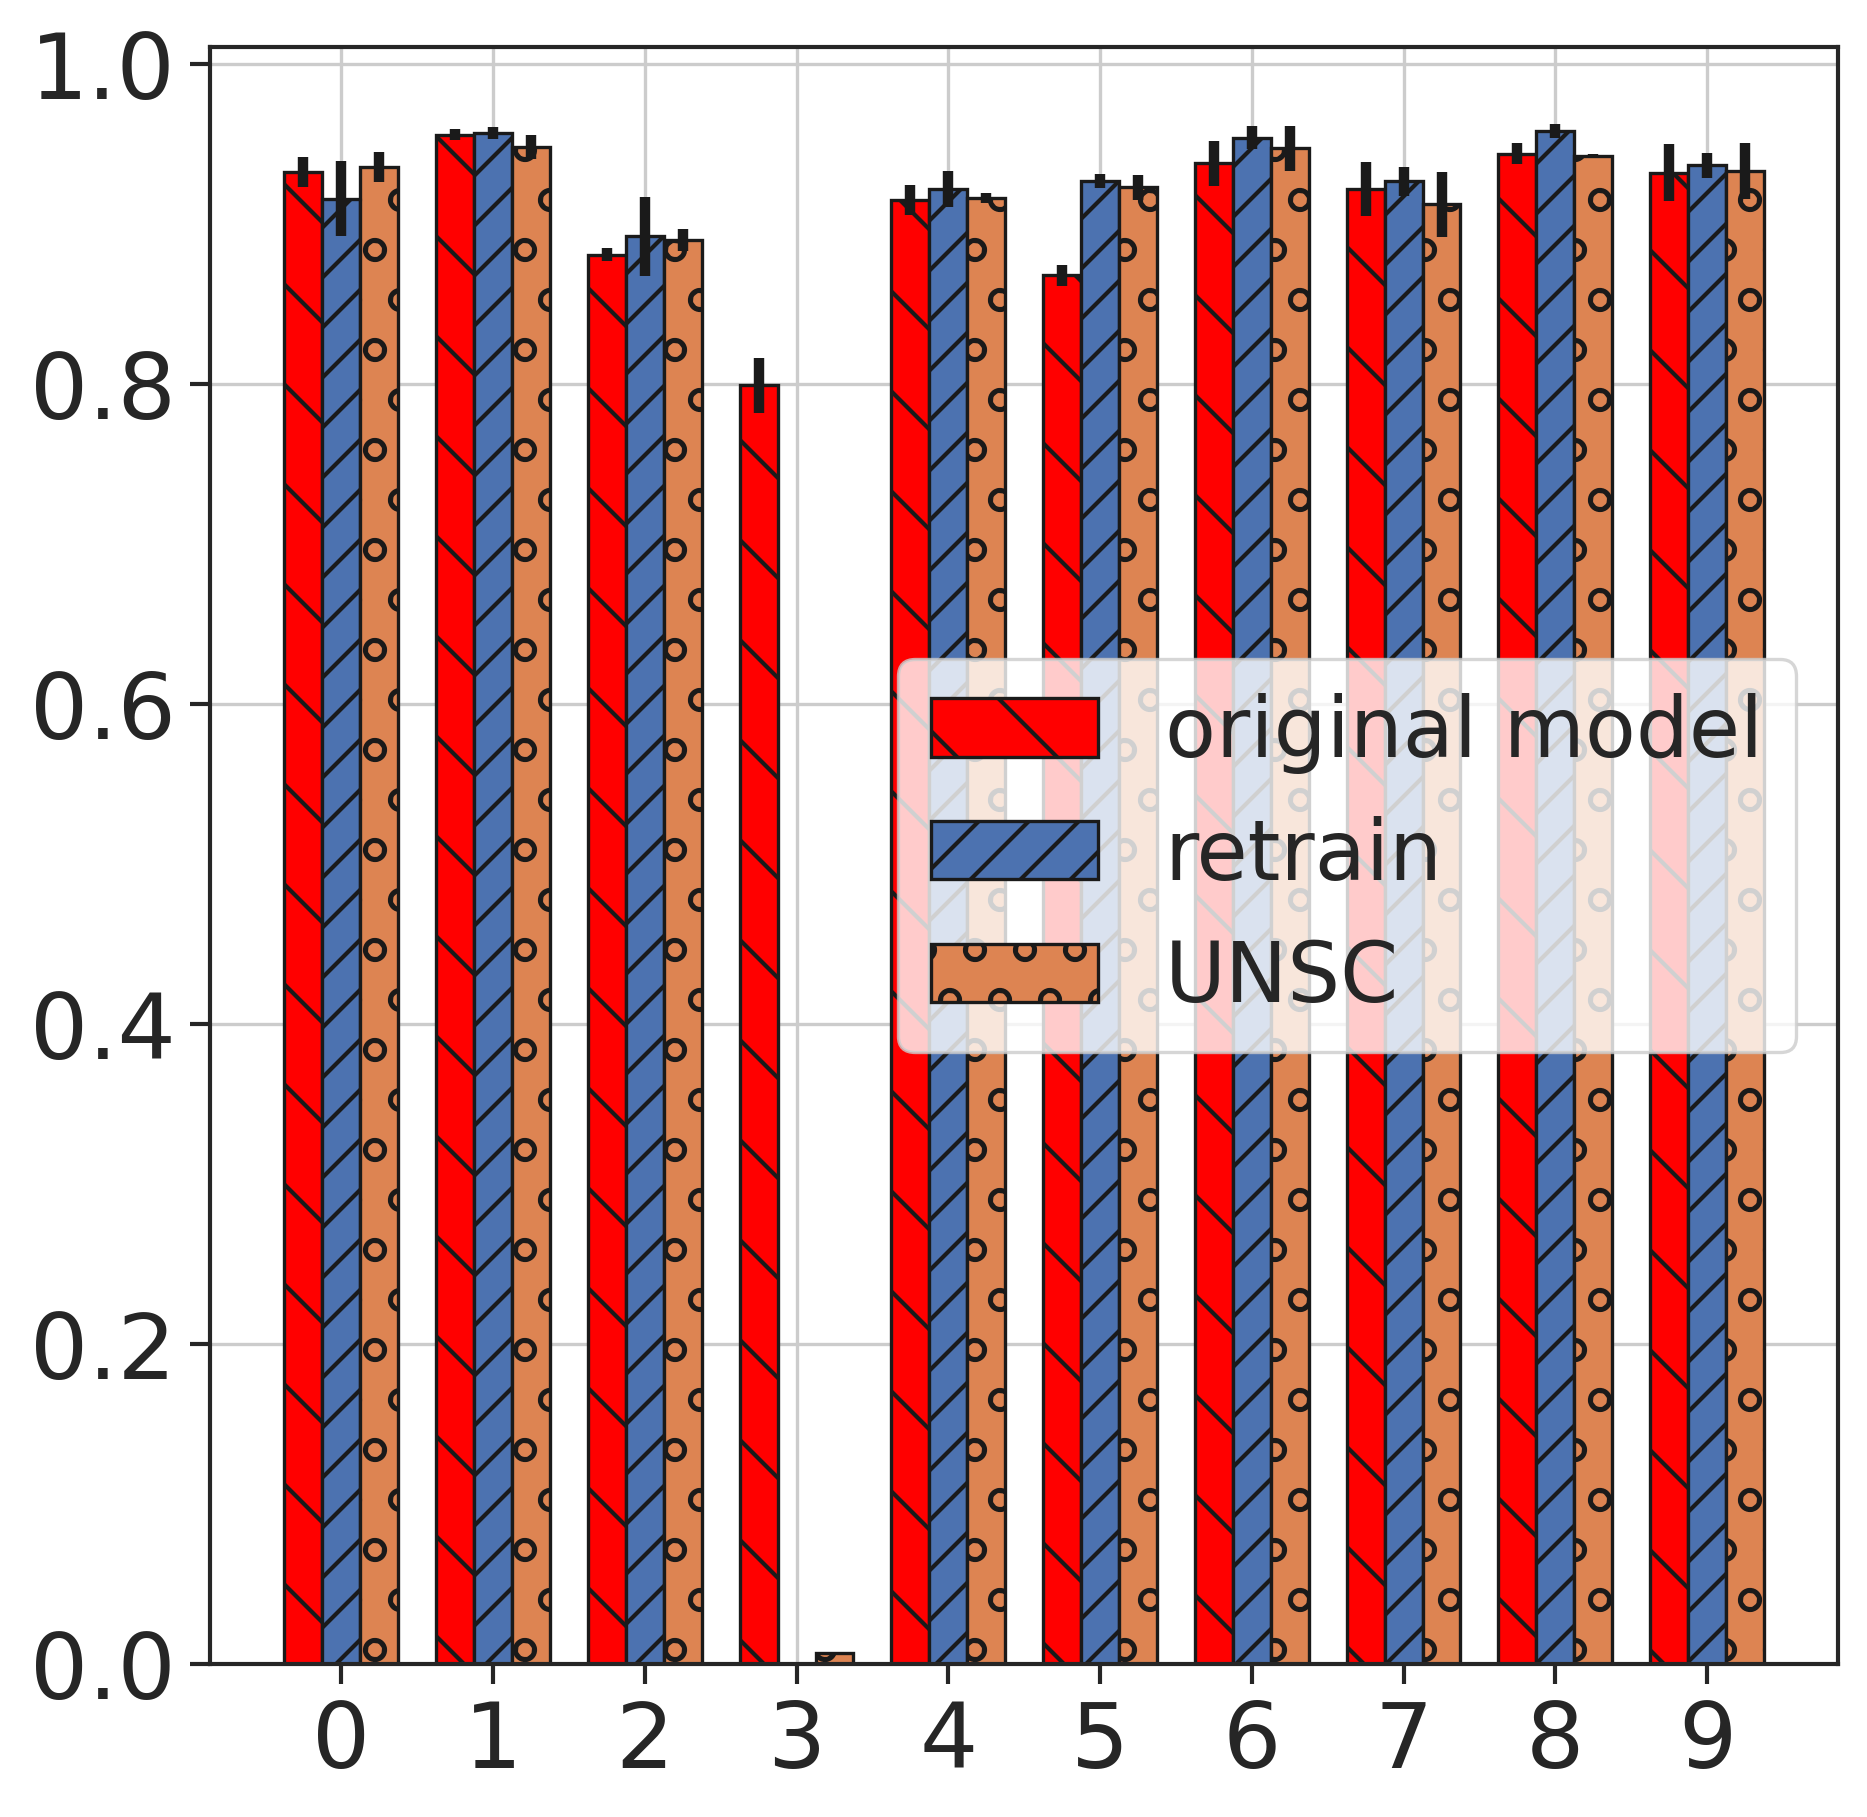

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="ticks")
sns.set_context(
    "paper",
    rc={
        "lines.linewidth": 2.5,
        "xtick.labelsize": 22,
        "ytick.labelsize": 22,
        "lines.markersize": 15,
        "legend.fontsize": 20,
        "axes.labelsize": 22,
        "axes.titlesize": 22,
        "legend.handlelength": 1,
        "legend.handleheight": 1,
    },
)


acc_o = np.array([[0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070],
                [0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420],
                [0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470]])

acc_r = np.array([[0.9250, 0.9590, 0.9040, 0.0000, 0.9260, 0.9290, 0.9540, 0.9150, 0.9560, 0.9440],
                [0.8840, 0.9520, 0.9150, 0.0000, 0.9070, 0.9310, 0.9450, 0.9370, 0.9640, 0.9400],
                [0.9390, 0.9600, 0.8580, 0.0000, 0.9330, 0.9210, 0.9630, 0.9280, 0.9540, 0.9260]])

acc_u = np.array([[0.9480, 0.9540, 0.8810, 0.0070, 0.9120, 0.9120, 0.9670, 0.9100, 0.9430, 0.9090],
                [0.9260, 0.9530, 0.8920, 0.0060, 0.9190, 0.9280, 0.9340, 0.9380, 0.9410, 0.9500],
                [0.9330, 0.9380, 0.8970, 0.0080, 0.9180, 0.9290, 0.9410, 0.8890, 0.9440, 0.9410]])

plt.figure(figsize=(7, 7), dpi=300)

mean_o = acc_o.mean(axis=0)
std_o = acc_o.std(axis=0)
mean_u = acc_u.mean(axis=0)
std_u = acc_u.std(axis=0)
mean_r = acc_r.mean(axis=0)
std_r = acc_r.std(axis=0)
x = np.arange(10)
width = 0.25

rects_o = plt.bar(x - width, mean_o, width, yerr=std_o, edgecolor='k', hatch='\\', color = 'red',label='original model')
rects_r = plt.bar(x , mean_r, width, yerr=std_r, hatch='//', edgecolor='k', label='retrain')
rects_u = plt.bar(x+ width, mean_u, width, yerr=std_u, hatch='o', edgecolor='k',label=r'UNSC')

plt.gca().set_xticks(x)
plt.grid()

plt.legend(loc='center right')

plt.show()



# Unlearn 2 classes

In [93]:
arxiv_name = dict[2]['arxiv_name']
args.unlearn_class = dict[2]['unlean_class']
Acc_r, Acc_f = np.zeros((2,3)), np.zeros((2,3))
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/original_model_12-20-02-15_{args.seeds[i]}.pth'))
    Acc_f[0][i], Acc_r[0][i] = test_by_class(model, test_loader, i=args.unlearn_class)

print('------------ Retrained model ------------')
for i in range(3):
    model_r = get_model(args)
    try:
        model_r.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/retrain_model_{arxiv_name}_{args.seeds[i]}.pth'))
        Acc_f[1][i], Acc_r[1][i] = test_by_class(model_r, test_loader, i=args.unlearn_class)
    except:
        print('No retrained model')
        break

print(f'Original model Acc_f: {100*Acc_f[0].mean():.2f} \pm {100*Acc_f[0].std():.2f}')
print(f'Original model Acc_r: {100*Acc_r[0].mean():.2f} \pm {100*Acc_r[0].std():.2f}')

print(f'Retrained model Acc_f: {100*Acc_f[1].mean():.2f} \pm {100*Acc_f[1].std():.2f}')
print(f'Retrained model Acc_r: {100*Acc_r[1].mean():.2f} \pm {100*Acc_r[1].std():.2f}')

arxiv_name = 'original_model_12-20-02-15'

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.8795, Acc_r: 0.9123
0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420, Acc_f: 0.8875, Acc_r: 0.9164
0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470, Acc_f: 0.8660, Acc_r: 0.9211
------------ Retrained model ------------
0.9250, 0.0000, 0.9040, 0.0000, 0.9360, 0.9210, 0.9440, 0.9260, 0.9550, 0.9600, Acc_f: 0.0000, Acc_r: 0.9339
0.9220, 0.0000, 0.8840, 0.0000, 0.9310, 0.9160, 0.9360, 0.9280, 0.9630, 0.9650, Acc_f: 0.0000, Acc_r: 0.9306
0.8980, 0.0000, 0.8860, 0.0000, 0.9260, 0.9220, 0.9550, 0.9410, 0.9620, 0.9570, Acc_f: 0.0000, Acc_r: 0.9309
Original model Acc_f: 87.77 \pm 0.89
Original model Acc_r: 91.66 \pm 0.36
Retrained model Acc_f: 0.00 \pm 0.00
Retrained model Acc_r: 93.18 \pm 0.15


In [96]:
args.unlearn_class = dict[2]['unlean_class']

train_loader, val_loader, test_loader = get_dataloader(args)
train_targets_list = np.array(train_loader.dataset.targets)[train_loader.sampler.indices]
unlearn_indices = np.where(np.isin(train_targets_list, args.unlearn_class))[0]

# conver to the original indices
unlearn_indices = train_loader.sampler.indices[unlearn_indices]

unlearn_sampler = torch.utils.data.SubsetRandomSampler(unlearn_indices)
unlearn_subset_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                                    batch_size=args.batch_size, 
                                                    sampler=unlearn_sampler)
remain_class = np.setdiff1d(np.arange(args.num_classes), args.unlearn_class)

remain_indices = np.where(~np.isin(train_targets_list, args.unlearn_class))[0]
remain_indices = train_loader.sampler.indices[remain_indices]

remain_sampler = torch.utils.data.SubsetRandomSampler(remain_indices)
remain_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                            batch_size=args.batch_size, 
                                            sampler=remain_sampler)

Files already downloaded and verified
Files already downloaded and verified


In [97]:
Proj_mat_lst =[]
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    print(f'------------ Trail {i} ------------')
    merged_feat_mat = []
    for cls_id in range(10): 
        cls_indices = np.where(np.isin(train_targets_list, cls_id))[0]
        cls_indices = train_loader.sampler.indices[cls_indices]
        cls_sampler = torch.utils.data.SubsetRandomSampler(cls_indices)
        cls_loader_dict = torch.utils.data.DataLoader(train_loader.dataset, 
                                                                batch_size=args.batch_size, 
                                                                sampler=cls_sampler)
        if cls_id in args.unlearn_class:
            continue
        for batch, (x, y) in enumerate(cls_loader_dict ):
            x = x.cuda()
            y = y.cuda()
            mat_list = get_representation_matrix(model, 
                                                x, 
                                                batch_list=[24, 100, 100, 125, 125, 250, 250, 256, 256])
            break
        threshold = 0.97 + 0.003*cls_id
        merged_feat_mat = update_GPM(mat_list, threshold, merged_feat_mat)
        proj_mat = [torch.Tensor(np.dot(layer_basis, layer_basis.transpose())) for layer_basis in merged_feat_mat]
        Proj_mat_lst.append(proj_mat)

------------ Trail 0 ------------


Threshold:  0.97
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 4/27
Layer 2 : 47/432
Layer 3 : 179/432
Layer 4 : 554/864
Layer 5 : 619/864
Layer 6 : 619/864
Layer 7 : 667/864
Layer 8 : 76/96
Layer 9 : 4/96
----------------------------------------
Threshold:  0.976
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 7/27
Layer 2 : 62/432
Layer 3 : 216/432
Layer 4 : 648/864
Layer 5 : 693/864
Layer 6 : 677/864
Layer 7 : 755/864
Layer 8 : 88/96
Layer 9 : 8/96
----------------------------------------
Threshold:  0.982
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 8/27
Layer 2 : 71/432
Layer 3 : 244/432
Layer 4 : 709/864
Layer 5 : 738/864
Layer 6 : 720/864
Layer 7 : 787/864
Layer 8 : 92/96
Layer 9 : 10/96
----------------------------------------
Threshold:  0.985
Skip Updating

In [100]:
def get_pseudo_label(args, model, x):
    masked_output = model(x)
    masked_output[:, args.unlearn_class] = -np.inf
    pseudo_labels = torch.topk(masked_output, k=1, dim=1).indices
    return pseudo_labels.reshape(-1)

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.04)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    model.eval()
    for ep in range(25):
        for batch, (x, y) in enumerate(unlearn_subset_loader):
            x = x.cuda()
            y = get_pseudo_label(args, model, x)
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            kk = 0 
            for k, (m,params) in enumerate(sgd_mr_model.named_parameters()):
                if len(params.size())!=1:
                    sz =  params.grad.data.size(0)
                    params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                            Proj_mat_lst[i][kk].cuda()).view(params.size())
                    kk +=1
                elif len(params.size())==1:
                    params.grad.data.fill_(0)
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.8795, Acc_r: 0.9123
[train] epoch 0, batch 17, loss 1.6242754459381104
0.9220, 0.4270, 0.8870, 0.2580, 0.9030, 0.9150, 0.9650, 0.8930, 0.9650, 0.9590, Acc_f: 0.3425, Acc_r: 0.9261
[train] epoch 1, batch 17, loss 0.7886655330657959
0.9170, 0.1540, 0.8980, 0.1140, 0.8990, 0.9200, 0.9680, 0.8820, 0.9660, 0.9480, Acc_f: 0.1340, Acc_r: 0.9247
[train] epoch 2, batch 17, loss 0.5347606539726257
0.9190, 0.0610, 0.9010, 0.0730, 0.8990, 0.9160, 0.9680, 0.8780, 0.9630, 0.9450, Acc_f: 0.0670, Acc_r: 0.9236
[train] epoch 3, batch 17, loss 0.559791088104248
0.9200, 0.0280, 0.8960, 0.0570, 0.9000, 0.9140, 0.9670, 0.8780, 0.9600, 0.9420, Acc_f: 0.0425, Acc_r: 0.9221
[train] epoch 4, batch 17, loss 0.4579369127750397
0.9240, 0.0170, 0.8950, 0.0500, 0.9050, 0.9140, 0.9670, 0.8770, 0.9560, 0.9440, Acc_f: 0.0335, Acc_r: 0.9227
[train] epoch 5, batch 17, loss 0.5190806984901428
0.9250, 0.0090, 0.8890, 0.0400, 0.9030, 0

In [ ]:
Acc_r = 100*np.array([0.9245, 0.9305, 0.9270])
Acc_f = 100*np.array([0.0020, 0.0060, 0.0100])

print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

In [4]:
a = (100*np.array([0.9245, 0.9305, 0.9270])-100*np.array([0.9123, 0.9164, 0.9211]))
a.mean(), a.std()

(1.073333333333333, 0.35046001515468245)

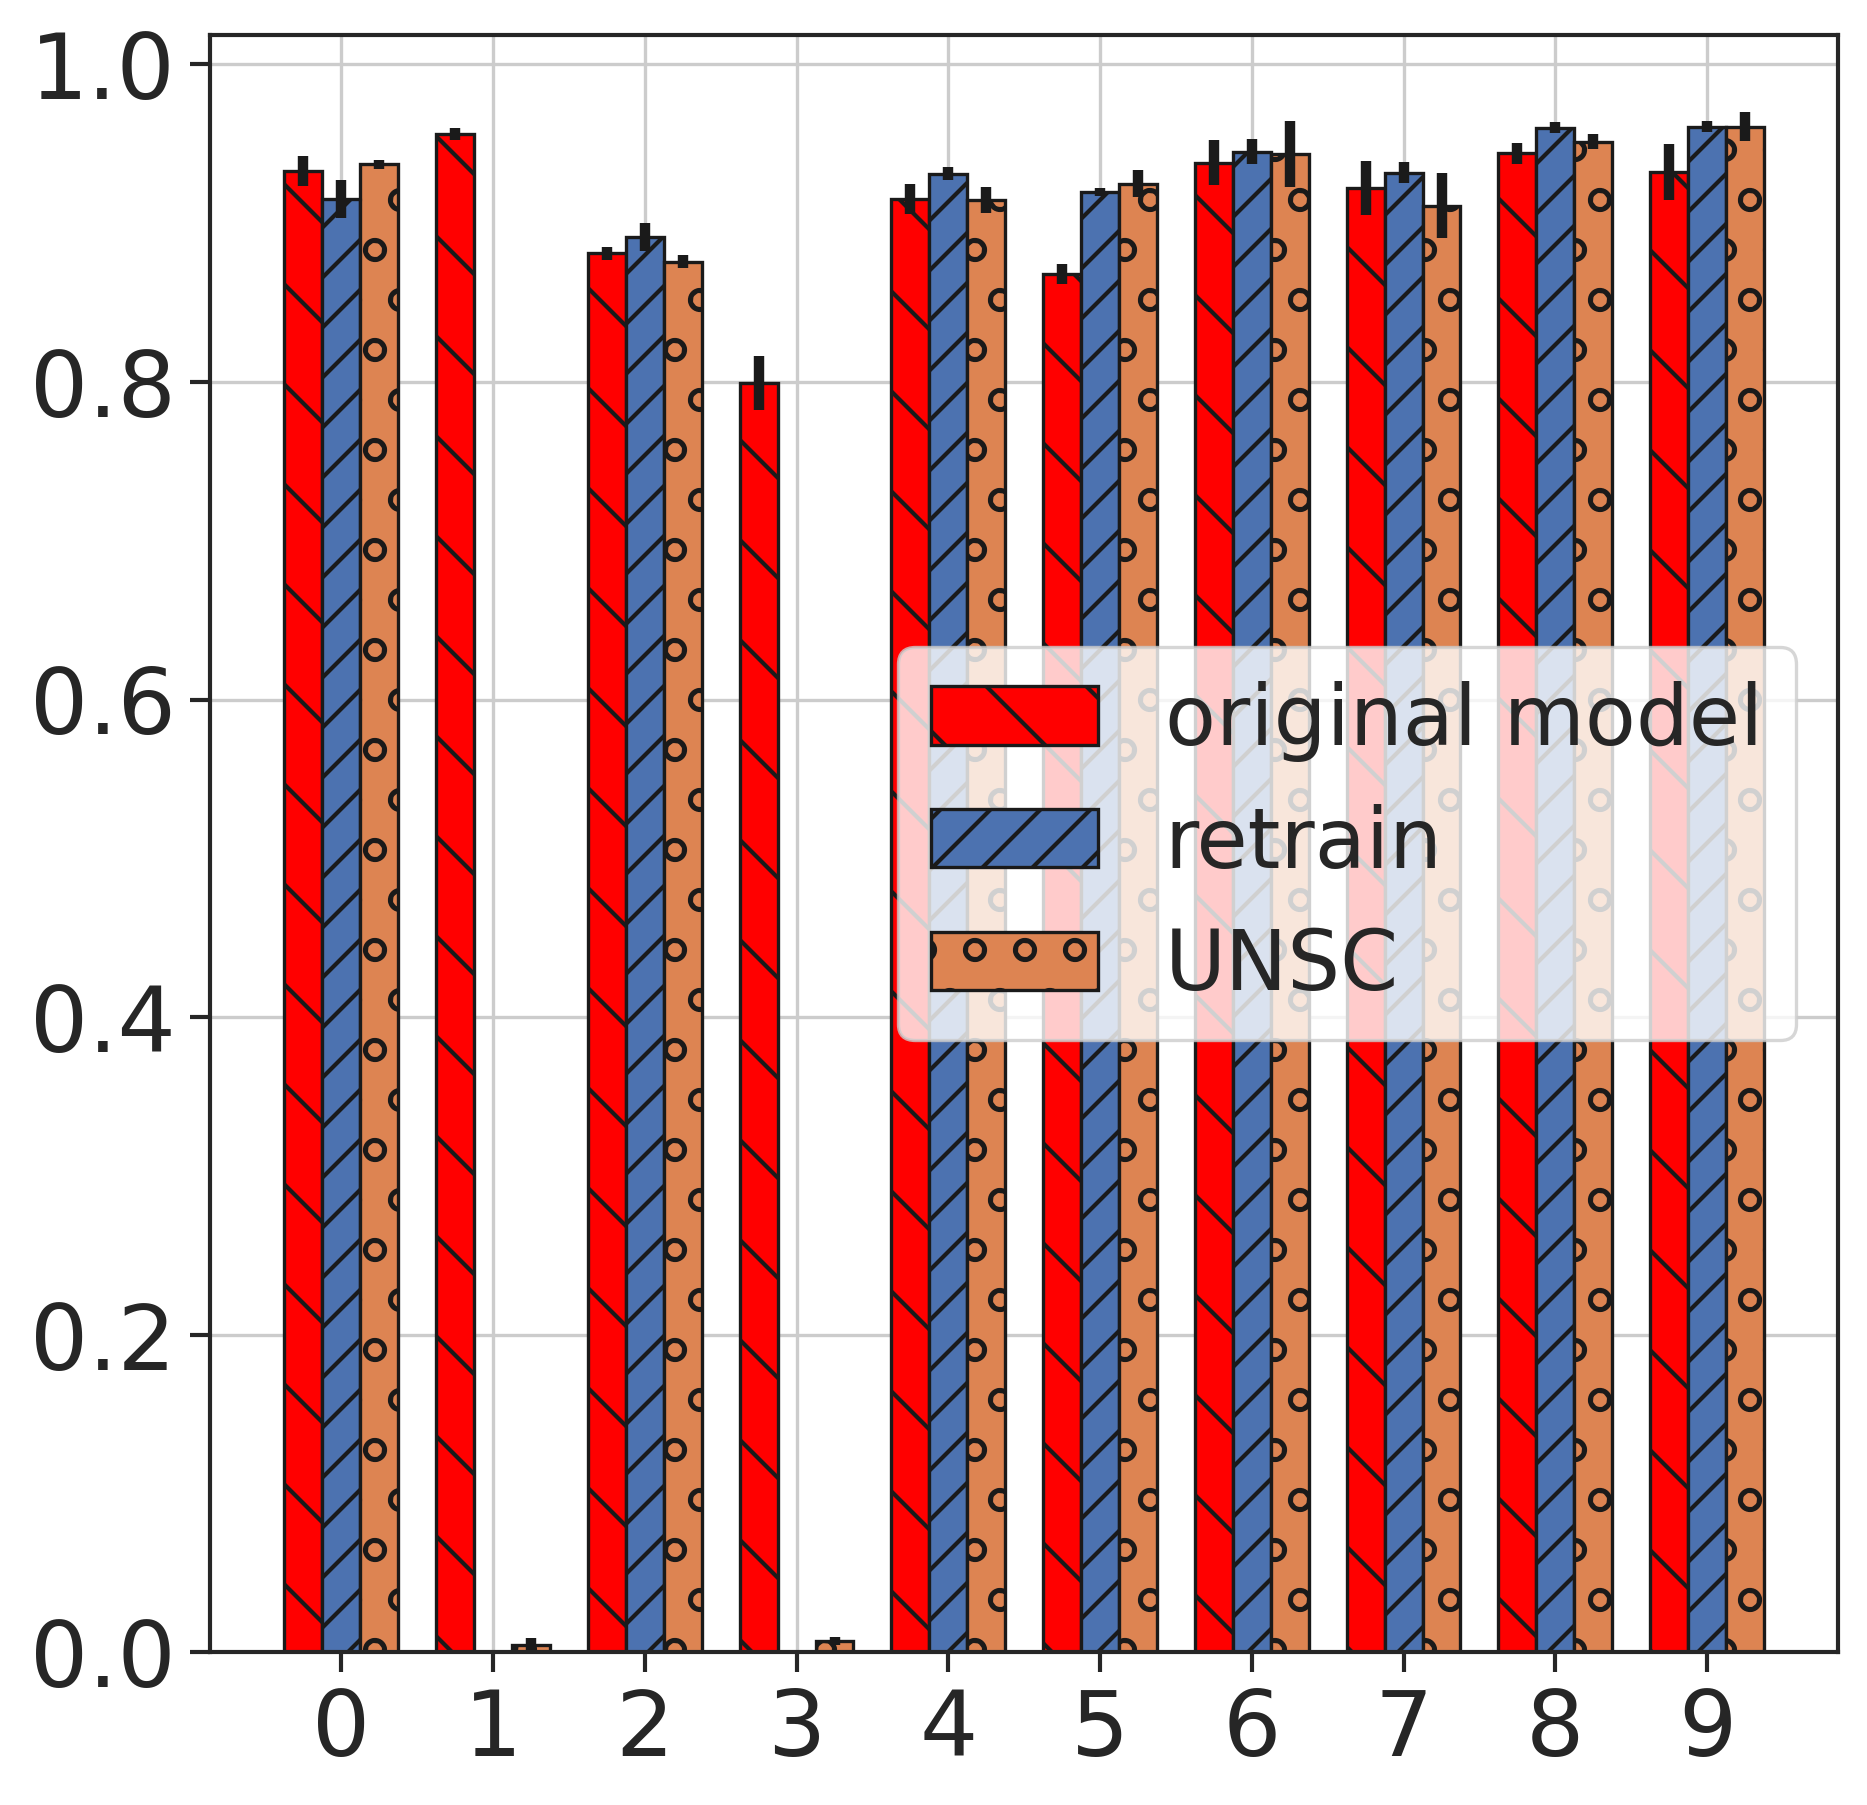

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="ticks")
sns.set_context(
    "paper",
    rc={
        "lines.linewidth": 2.5,
        "xtick.labelsize": 22,
        "ytick.labelsize": 22,
        "lines.markersize": 15,
        "legend.fontsize": 20,
        "axes.labelsize": 22,
        "axes.titlesize": 22,
        "legend.handlelength": 1,
        "legend.handleheight": 1,
    },
)

acc_o = np.array([[0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070],
                [0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420],
                [0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470]])

acc_r = np.array([[0.9250, 0.0000, 0.9040, 0.0000, 0.9360, 0.9210, 0.9440, 0.9260, 0.9550, 0.9600],
                [0.9220, 0.0000, 0.8840, 0.0000, 0.9310, 0.9160, 0.9360, 0.9280, 0.9630, 0.9650],
                [0.8980, 0.0000, 0.8860, 0.0000, 0.9260, 0.9220, 0.9550, 0.9410, 0.9620, 0.9570]])

acc_u = np.array([[0.9390, 0.0000, 0.8790, 0.0040, 0.9040, 0.9130, 0.9710, 0.8920, 0.9500, 0.9480],
                [0.9330, 0.0040, 0.8700, 0.0080, 0.9160, 0.9330, 0.9390, 0.9390, 0.9460, 0.9680],
                [0.9390, 0.0100, 0.8780, 0.0100, 0.9240, 0.9280, 0.9210, 0.9020, 0.9580, 0.9660]])

plt.figure(figsize=(7, 7), dpi=300)

mean_o = acc_o.mean(axis=0)
std_o = acc_o.std(axis=0)
mean_u = acc_u.mean(axis=0)
std_u = acc_u.std(axis=0)
mean_r = acc_r.mean(axis=0)
std_r = acc_r.std(axis=0)
x = np.arange(10)
width = 0.25

rects_o = plt.bar(x - width, mean_o, width, yerr=std_o, edgecolor='k', hatch='\\', color = 'red',label='original model')
rects_r = plt.bar(x, mean_r, width, yerr=std_r, hatch='//', edgecolor='k', label='retrain')
rects_u = plt.bar(x + width, mean_u, width, yerr=std_u, hatch='o', edgecolor='k',label=r'UNSC')

plt.gca().set_xticks(x)
plt.grid()

plt.legend(loc='center right')

plt.show()



# Unlearn 3 classes


In [89]:
arxiv_name = dict[3]['arxiv_name']
args.unlearn_class = dict[3]['unlean_class']
Acc_r, Acc_f = np.zeros((2,3)), np.zeros((2,3))
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/original_model_12-20-02-15_{args.seeds[i]}.pth'))
    Acc_f[0][i], Acc_r[0][i] = test_by_class(model, test_loader, i=args.unlearn_class)

print('------------ Retrained model ------------')
for i in range(3):
    model_r = get_model(args)
    try:
        model_r.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/retrain_model_{arxiv_name}_{args.seeds[i]}.pth'))
        Acc_f[1][i], Acc_r[1][i] = test_by_class(model_r, test_loader, i=args.unlearn_class)
    except:
        print('No retrained model')
        break

print(f'Original model Acc_f: {100*Acc_f[0].mean():.2f} \pm {100*Acc_f[0].std():.2f}')
print(f'Original model Acc_r: {100*Acc_r[0].mean():.2f} \pm {100*Acc_r[0].std():.2f}')

print(f'Retrained model Acc_f: {100*Acc_f[1].mean():.2f} \pm {100*Acc_f[1].std():.2f}')
print(f'Retrained model Acc_r: {100*Acc_r[1].mean():.2f} \pm {100*Acc_r[1].std():.2f}')

arxiv_name = 'original_model_12-20-02-15'

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.8727, Acc_r: 0.9199
0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420, Acc_f: 0.8830, Acc_r: 0.9224
0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470, Acc_f: 0.8677, Acc_r: 0.9283
------------ Retrained model ------------
0.9350, 0.0000, 0.8920, 0.0000, 0.9370, 0.0000, 0.9640, 0.9460, 0.9480, 0.9730, Acc_f: 0.0000, Acc_r: 0.9421
0.9300, 0.0000, 0.8990, 0.0000, 0.9490, 0.0000, 0.9450, 0.9560, 0.9450, 0.9590, Acc_f: 0.0000, Acc_r: 0.9404
0.9420, 0.0000, 0.9120, 0.0000, 0.9570, 0.0000, 0.9590, 0.9390, 0.9390, 0.9640, Acc_f: 0.0000, Acc_r: 0.9446
Original model Acc_f: 87.44 \pm 0.64
Original model Acc_r: 92.35 \pm 0.35
Retrained model Acc_f: 0.00 \pm 0.00
Retrained model Acc_r: 94.24 \pm 0.17


In [90]:
train_loader, val_loader, test_loader = get_dataloader(args)
train_targets_list = np.array(train_loader.dataset.targets)[train_loader.sampler.indices]
unlearn_indices = np.where(np.isin(train_targets_list, args.unlearn_class))[0]

# conver to the original indices
unlearn_indices = train_loader.sampler.indices[unlearn_indices]

unlearn_sampler = torch.utils.data.SubsetRandomSampler(unlearn_indices)
unlearn_subset_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                                    batch_size=args.batch_size, 
                                                    sampler=unlearn_sampler)
remain_class = np.setdiff1d(np.arange(args.num_classes), args.unlearn_class)

remain_indices = np.where(~np.isin(train_targets_list, args.unlearn_class))[0]
remain_indices = train_loader.sampler.indices[remain_indices]

remain_sampler = torch.utils.data.SubsetRandomSampler(remain_indices)
remain_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                            batch_size=args.batch_size, 
                                            sampler=remain_sampler)

Proj_mat_lst =[]
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    print(f'------------ Trail {i} ------------')
    merged_feat_mat = []
    for cls_id in range(10): 
        cls_indices = np.where(np.isin(train_targets_list, cls_id))[0]
        cls_indices = train_loader.sampler.indices[cls_indices]
        cls_sampler = torch.utils.data.SubsetRandomSampler(cls_indices)
        cls_loader_dict = torch.utils.data.DataLoader(train_loader.dataset, 
                                                                batch_size=args.batch_size, 
                                                                sampler=cls_sampler)
        if cls_id in args.unlearn_class:
            continue
        for batch, (x, y) in enumerate(cls_loader_dict ):
            x = x.cuda()
            y = y.cuda()
            mat_list = get_representation_matrix(model, 
                                                x, 
                                                batch_list=[24, 100, 100, 125, 125, 250, 250, 256, 256])
            break
        threshold = 0.97 + 0.003*cls_id
        merged_feat_mat = update_GPM(mat_list, threshold, merged_feat_mat)
        proj_mat = [torch.Tensor(np.dot(layer_basis, layer_basis.transpose())) for layer_basis in merged_feat_mat]
        Proj_mat_lst.append(proj_mat)


Files already downloaded and verified
Files already downloaded and verified
------------ Trail 0 ------------
Threshold:  0.97
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 5/27
Layer 2 : 49/432
Layer 3 : 181/432
Layer 4 : 557/864
Layer 5 : 619/864
Layer 6 : 620/864
Layer 7 : 670/864
Layer 8 : 76/96
Layer 9 : 4/96
----------------------------------------
Threshold:  0.976
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 7/27
Layer 2 : 59/432
Layer 3 : 212/432
Layer 4 : 650/864
Layer 5 : 693/864
Layer 6 : 678/864
Layer 7 : 757/864
Layer 8 : 88/96
Layer 9 : 8/96
----------------------------------------
Threshold:  0.982
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 8/27
Layer 2 : 72/432
Layer 3 : 243/432
Layer 4 : 704/864
Layer 5 : 736/864
Layer 6 : 719/864
Layer 7 : 78

In [91]:
def get_pseudo_label(args, model, x):
    masked_output = model(x)
    masked_output[:, args.unlearn_class] = -np.inf
    pseudo_labels = torch.topk(masked_output, k=1, dim=1).indices
    return pseudo_labels.reshape(-1)

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.04)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    model.eval()
    for ep in range(25):
        for batch, (x, y) in enumerate(unlearn_subset_loader):
            x = x.cuda()
            y = get_pseudo_label(args, model, x)
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            kk = 0 
            for k, (m,params) in enumerate(sgd_mr_model.named_parameters()):
                if len(params.size())!=1:
                    sz =  params.grad.data.size(0)
                    params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                            Proj_mat_lst[i][kk].cuda()).view(params.size())
                    kk +=1
                elif len(params.size())==1:
                    params.grad.data.fill_(0)
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.8727, Acc_r: 0.9199
[train] epoch 0, batch 26, loss 1.7692084312438965
0.8860, 0.4480, 0.8700, 0.1550, 0.9100, 0.0760, 0.9480, 0.8980, 0.9690, 0.9470, Acc_f: 0.2263, Acc_r: 0.9183
[train] epoch 1, batch 26, loss 1.0091466903686523
0.9080, 0.2070, 0.8830, 0.1140, 0.9200, 0.0530, 0.9590, 0.9200, 0.9630, 0.9430, Acc_f: 0.1247, Acc_r: 0.9280
[train] epoch 2, batch 26, loss 0.6982631087303162
0.9220, 0.1080, 0.8830, 0.0890, 0.9120, 0.0380, 0.9680, 0.9170, 0.9620, 0.9390, Acc_f: 0.0783, Acc_r: 0.9290
[train] epoch 3, batch 26, loss 0.5673158764839172
0.9350, 0.0560, 0.8860, 0.0800, 0.9240, 0.0340, 0.9670, 0.9240, 0.9590, 0.9400, Acc_f: 0.0567, Acc_r: 0.9336
[train] epoch 4, batch 26, loss 0.5916770100593567
0.9430, 0.0360, 0.8880, 0.0580, 0.9180, 0.0270, 0.9680, 0.9290, 0.9540, 0.9360, Acc_f: 0.0403, Acc_r: 0.9337
[train] epoch 5, batch 26, loss 0.5266324281692505
0.9480, 0.0200, 0.8870, 0.0500, 0.9090, 

In [ ]:
Acc_r = 100*np.array([0.9369,0.9430, 0.9354])
Acc_f = 100*np.array([0.0043,0.0073,0.0150])

print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

In [5]:
a = (100*np.array([0.9369,0.9430, 0.9354])-100*np.array([0.9199, 0.9224, 0.9283]))
a.mean(), a.std()

(1.4899999999999995, 0.5707889277132092)

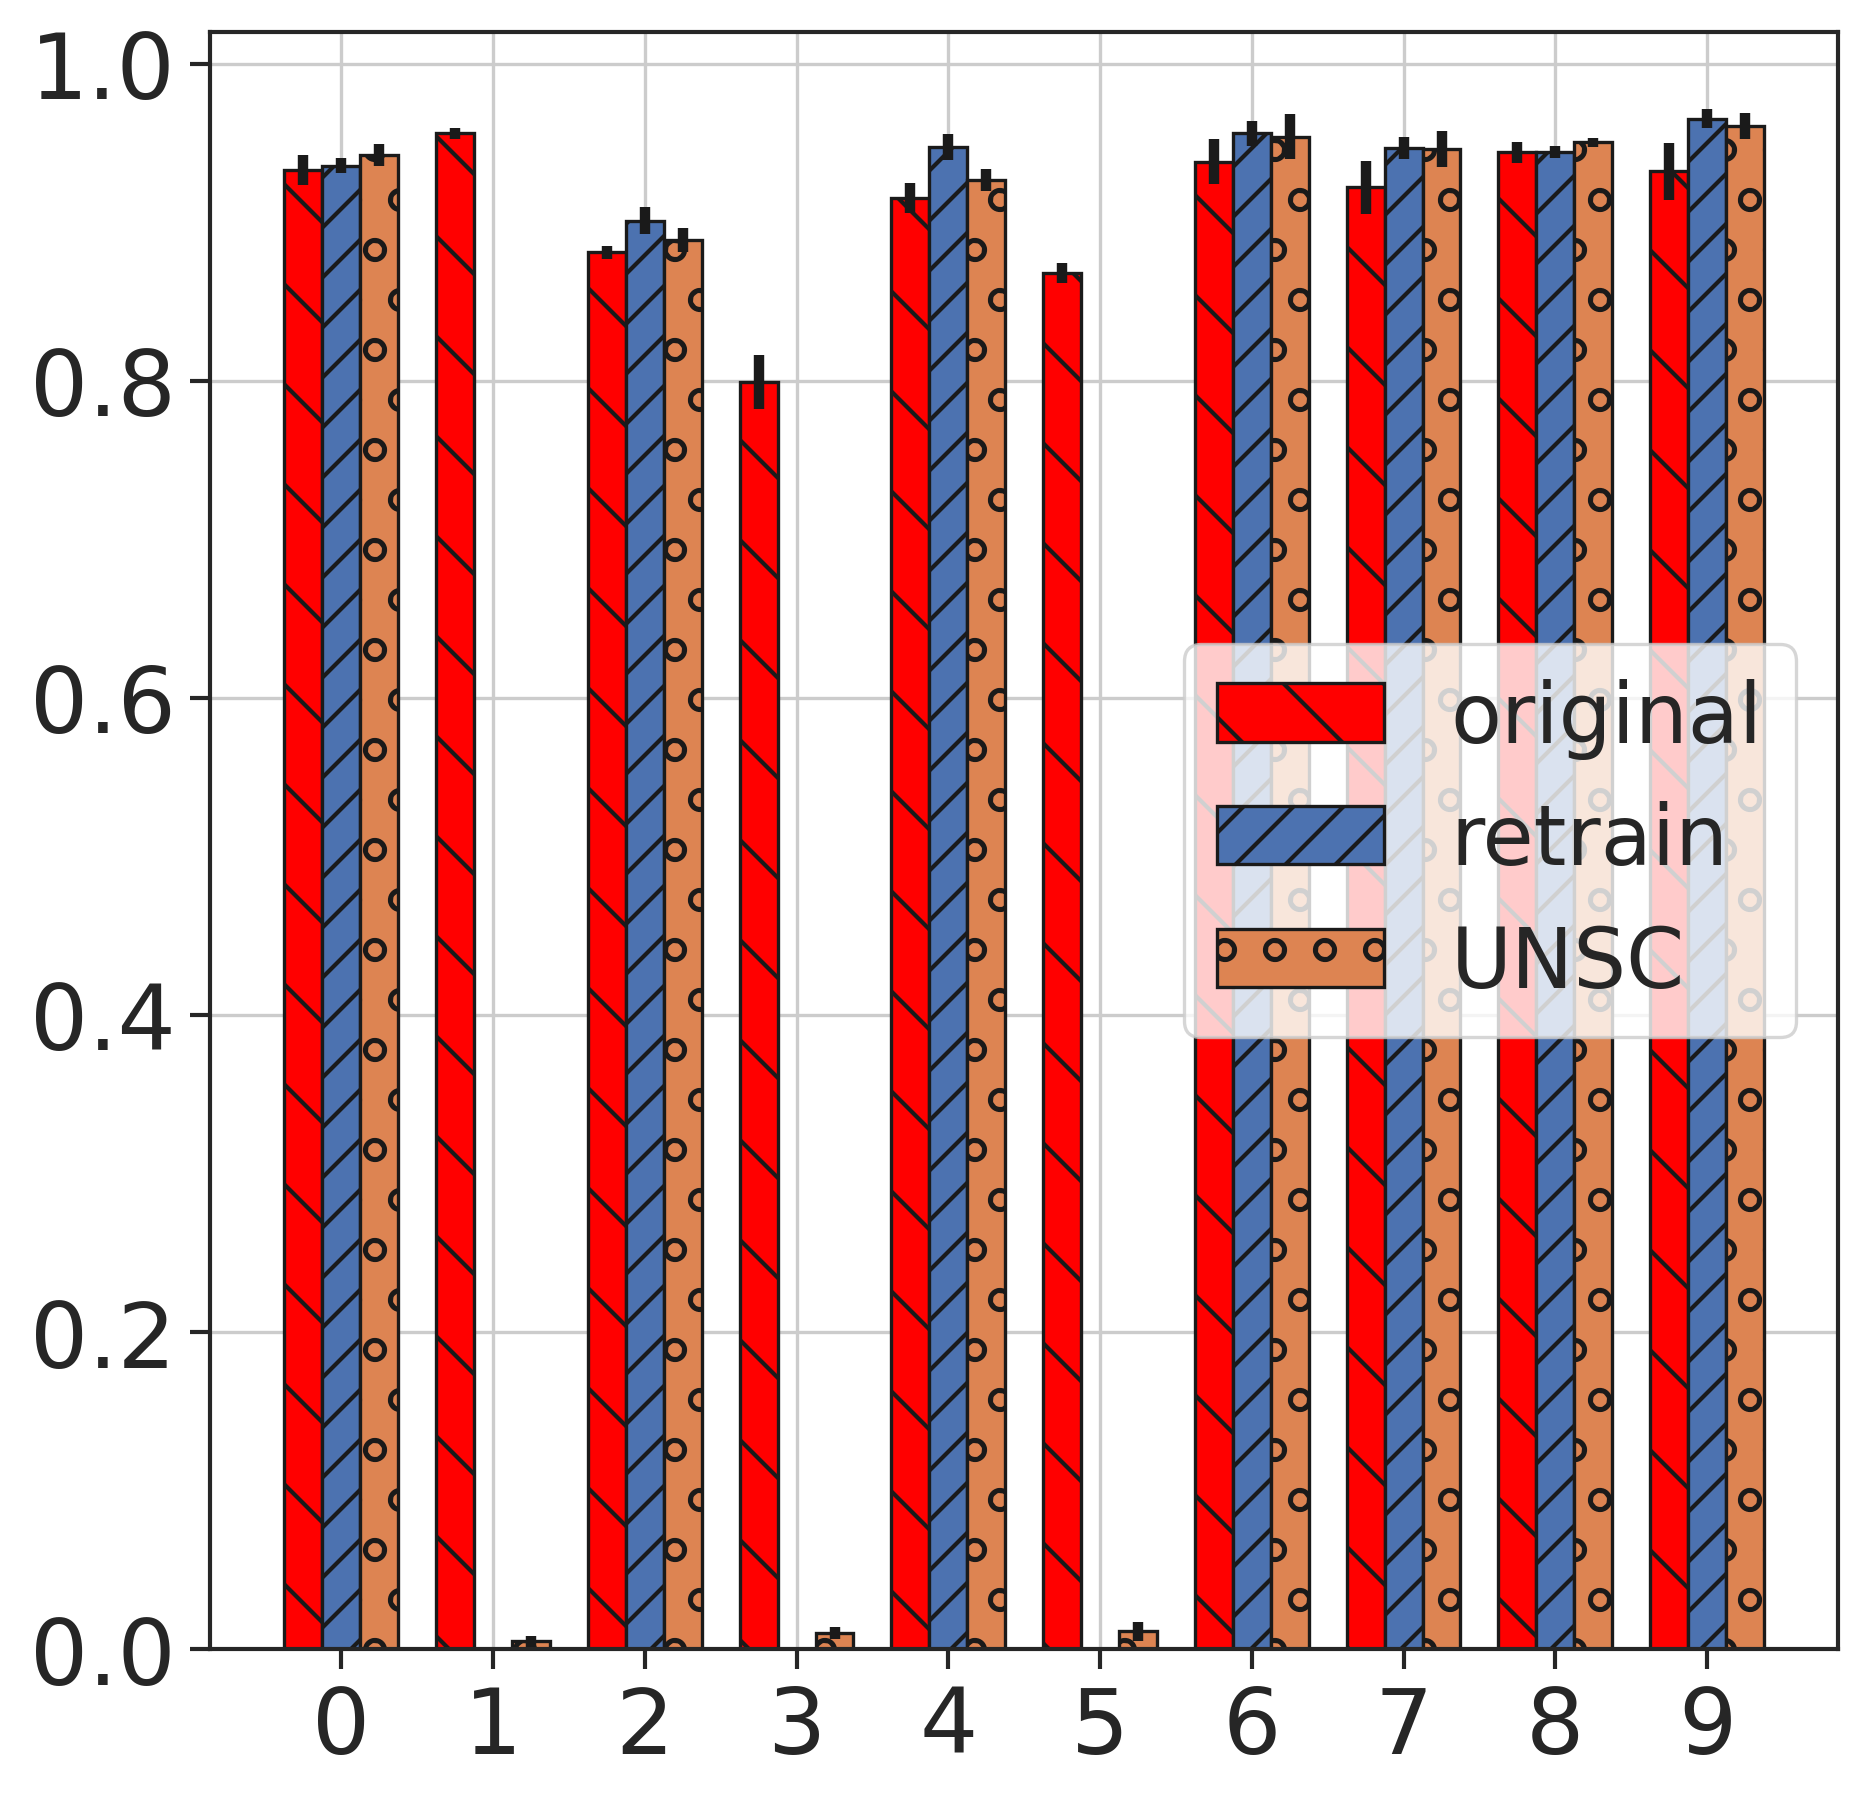

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="ticks")
sns.set_context(
    "paper",
    rc={
        "lines.linewidth": 2.5,
        "xtick.labelsize": 22,
        "ytick.labelsize": 22,
        "lines.markersize": 15,
        "legend.fontsize": 20,
        "axes.labelsize": 22,
        "axes.titlesize": 22,
        "legend.handlelength": 1,
        "legend.handleheight": 1,
    },
)

acc_o = np.array([[0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070],
                [0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420],
                [0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470]])

acc_r = np.array([[0.9350, 0.0000, 0.8920, 0.0000, 0.9370, 0.0000, 0.9640, 0.9460, 0.9480, 0.9730],
                [0.9300, 0.0000, 0.8990, 0.0000, 0.9490, 0.0000, 0.9450, 0.9560, 0.9450, 0.9590],
                [0.9420, 0.0000, 0.9120, 0.0000, 0.9570, 0.0000, 0.9590, 0.9390, 0.9390, 0.9640]])

acc_u = np.array([[0.9520, 0.0000, 0.8790, 0.0070, 0.9190, 0.0060, 0.9720, 0.9350, 0.9500, 0.9510],
                [0.9360, 0.0060, 0.8970, 0.0080, 0.9360, 0.0080, 0.9520, 0.9620, 0.9470, 0.9710],
                [0.9390, 0.0090, 0.8900, 0.0160, 0.9250, 0.0200, 0.9380, 0.9420, 0.9540, 0.9600]])

plt.figure(figsize=(7, 7), dpi=300)

mean_o = acc_o.mean(axis=0)
std_o = acc_o.std(axis=0)
mean_u = acc_u.mean(axis=0)
std_u = acc_u.std(axis=0)
mean_r = acc_r.mean(axis=0)
std_r = acc_r.std(axis=0)
x = np.arange(10)
width = 0.25

rects_o = plt.bar(x - width, mean_o, width, yerr=std_o, edgecolor='k', hatch='\\', color = 'red',label='original')
rects_r = plt.bar(x, mean_r, width, yerr=std_r, hatch='//', edgecolor='k', label='retrain')
rects_u = plt.bar(x + width, mean_u, width, yerr=std_u, hatch='o', edgecolor='k',label=r'UNSC')

plt.gca().set_xticks(x)
plt.grid()

plt.legend(loc='center right')

plt.show()


# Unlearn 4 classes

In [85]:
arxiv_name = dict[4]['arxiv_name']
args.unlearn_class = dict[4]['unlean_class']
Acc_r, Acc_f = np.zeros((2,3)), np.zeros((2,3))
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/original_model_12-20-02-15_{args.seeds[i]}.pth'))
    Acc_f[0][i], Acc_r[0][i] = test_by_class(model, test_loader, i=args.unlearn_class)

print('------------ Retrained model ------------')
for i in range(3):
    model_r = get_model(args)
    try:
        model_r.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/retrain_model_{arxiv_name}_{args.seeds[i]}.pth'))
        Acc_f[1][i], Acc_r[1][i] = test_by_class(model_r, test_loader, i=args.unlearn_class)
    except:
        print('No retrained model')
        break

print(f'Original model Acc_f: {100*Acc_f[0].mean():.2f} \pm {100*Acc_f[0].std():.2f}')
print(f'Original model Acc_r: {100*Acc_r[0].mean():.2f} \pm {100*Acc_r[0].std():.2f}')

print(f'Retrained model Acc_f: {100*Acc_f[1].mean():.2f} \pm {100*Acc_f[1].std():.2f}')
print(f'Retrained model Acc_r: {100*Acc_r[1].mean():.2f} \pm {100*Acc_r[1].std():.2f}')

arxiv_name = 'original_model_12-20-02-15'

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.8792, Acc_r: 0.9233
0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420, Acc_f: 0.8970, Acc_r: 0.9197
0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470, Acc_f: 0.8827, Acc_r: 0.9283
------------ Retrained model ------------
0.9430, 0.0000, 0.9100, 0.0000, 0.9560, 0.0000, 0.9540, 0.0000, 0.9560, 0.9680, Acc_f: 0.0000, Acc_r: 0.9478
0.9210, 0.0000, 0.8900, 0.0000, 0.9400, 0.0000, 0.9520, 0.0000, 0.9580, 0.9760, Acc_f: 0.0000, Acc_r: 0.9395
0.9270, 0.0000, 0.9130, 0.0000, 0.9380, 0.0000, 0.9520, 0.0000, 0.9580, 0.9580, Acc_f: 0.0000, Acc_r: 0.9410
Original model Acc_f: 88.63 \pm 0.77
Original model Acc_r: 92.38 \pm 0.36
Retrained model Acc_f: 0.00 \pm 0.00
Retrained model Acc_r: 94.28 \pm 0.36


In [86]:
unlearn_indices = np.where(np.isin(train_targets_list, args.unlearn_class))[0]

# conver to the original indices
unlearn_indices = train_loader.sampler.indices[unlearn_indices]

unlearn_sampler = torch.utils.data.SubsetRandomSampler(unlearn_indices)
unlearn_subset_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                                    batch_size=args.batch_size, 
                                                    sampler=unlearn_sampler)
remain_class = np.setdiff1d(np.arange(args.num_classes), args.unlearn_class)

remain_indices = np.where(~np.isin(train_targets_list, args.unlearn_class))[0]
remain_indices = train_loader.sampler.indices[remain_indices]

remain_sampler = torch.utils.data.SubsetRandomSampler(remain_indices)
remain_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                            batch_size=args.batch_size, 
                                            sampler=remain_sampler)

Proj_mat_lst =[]
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    print(f'------------ Trail {i} ------------')
    merged_feat_mat = []
    for cls_id in range(10): 
        cls_indices = np.where(np.isin(train_targets_list, cls_id))[0]
        cls_indices = train_loader.sampler.indices[cls_indices]
        cls_sampler = torch.utils.data.SubsetRandomSampler(cls_indices)
        cls_loader_dict = torch.utils.data.DataLoader(train_loader.dataset, 
                                                                batch_size=args.batch_size, 
                                                                sampler=cls_sampler)
        if cls_id in args.unlearn_class:
            continue
        for batch, (x, y) in enumerate(cls_loader_dict ):
            x = x.cuda()
            y = y.cuda()
            mat_list = get_representation_matrix(model, 
                                                x, 
                                                batch_list=[24, 100, 100, 125, 125, 250, 250, 256, 256])
            break
        threshold = 0.97 + 0.003*cls_id
        merged_feat_mat = update_GPM(mat_list, threshold, merged_feat_mat)
        proj_mat = [torch.Tensor(np.dot(layer_basis, layer_basis.transpose())) for layer_basis in merged_feat_mat]
        Proj_mat_lst.append(proj_mat)


------------ Trail 0 ------------
Threshold:  0.97
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 5/27
Layer 2 : 49/432
Layer 3 : 183/432
Layer 4 : 555/864
Layer 5 : 619/864
Layer 6 : 621/864
Layer 7 : 665/864
Layer 8 : 75/96
Layer 9 : 4/96
----------------------------------------
Threshold:  0.976
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 7/27
Layer 2 : 60/432
Layer 3 : 215/432
Layer 4 : 644/864
Layer 5 : 690/864
Layer 6 : 678/864
Layer 7 : 756/864
Layer 8 : 88/96
Layer 9 : 8/96
----------------------------------------
Threshold:  0.982
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 8/27
Layer 2 : 70/432
Layer 3 : 244/432
Layer 4 : 708/864
Layer 5 : 739/864
Layer 6 : 721/864
Layer 7 : 788/864
Layer 8 : 92/96
Layer 9 : 10/96
--------------------------------------

In [87]:
def get_pseudo_label(args, model, x):
    masked_output = model(x)
    masked_output[:, args.unlearn_class] = -np.inf
    pseudo_labels = torch.topk(masked_output, k=1, dim=1).indices
    return pseudo_labels.reshape(-1)

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.04)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    model.eval()
    for ep in range(25):
        for batch, (x, y) in enumerate(unlearn_subset_loader):
            x = x.cuda()
            y = get_pseudo_label(args, model, x)
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            kk = 0 
            for k, (m,params) in enumerate(sgd_mr_model.named_parameters()):
                if len(params.size())!=1:
                    sz =  params.grad.data.size(0)
                    params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                            Proj_mat_lst[i][kk].cuda()).view(params.size())
                    kk +=1
                elif len(params.size())==1:
                    params.grad.data.fill_(0)
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.8792, Acc_r: 0.9233
[train] epoch 0, batch 35, loss 1.23568594455719
0.9010, 0.4310, 0.8760, 0.1330, 0.9190, 0.0530, 0.9720, 0.0800, 0.9650, 0.9410, Acc_f: 0.1743, Acc_r: 0.9290
[train] epoch 1, batch 35, loss 0.7198920845985413
0.9180, 0.1840, 0.8850, 0.0890, 0.9280, 0.0430, 0.9690, 0.0460, 0.9610, 0.9410, Acc_f: 0.0905, Acc_r: 0.9337
[train] epoch 2, batch 35, loss 0.6311068534851074
0.9360, 0.1010, 0.8830, 0.0660, 0.9220, 0.0320, 0.9740, 0.0310, 0.9560, 0.9400, Acc_f: 0.0575, Acc_r: 0.9352
[train] epoch 3, batch 35, loss 0.7038785815238953
0.9410, 0.0540, 0.8890, 0.0450, 0.9190, 0.0210, 0.9730, 0.0220, 0.9520, 0.9410, Acc_f: 0.0355, Acc_r: 0.9358
[train] epoch 4, batch 35, loss 0.6717749834060669
0.9430, 0.0340, 0.8840, 0.0390, 0.9270, 0.0170, 0.9710, 0.0190, 0.9490, 0.9410, Acc_f: 0.0273, Acc_r: 0.9358
[train] epoch 5, batch 35, loss 0.33119139075279236
0.9420, 0.0210, 0.8800, 0.0320, 0.9240, 0

In [ ]:
Acc_r = 100*np.array([0.9395, 0.9437, 0.9392])
Acc_f = 100*np.array([0.0003,  0.0030, 0.0060])

print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

In [6]:
a = (100*np.array([0.9395, 0.9437, 0.9392])-100*np.array([0.9233, 0.9197, 0.9283]))
a.mean(), a.std()

(1.7033333333333378, 0.5380417166808629)

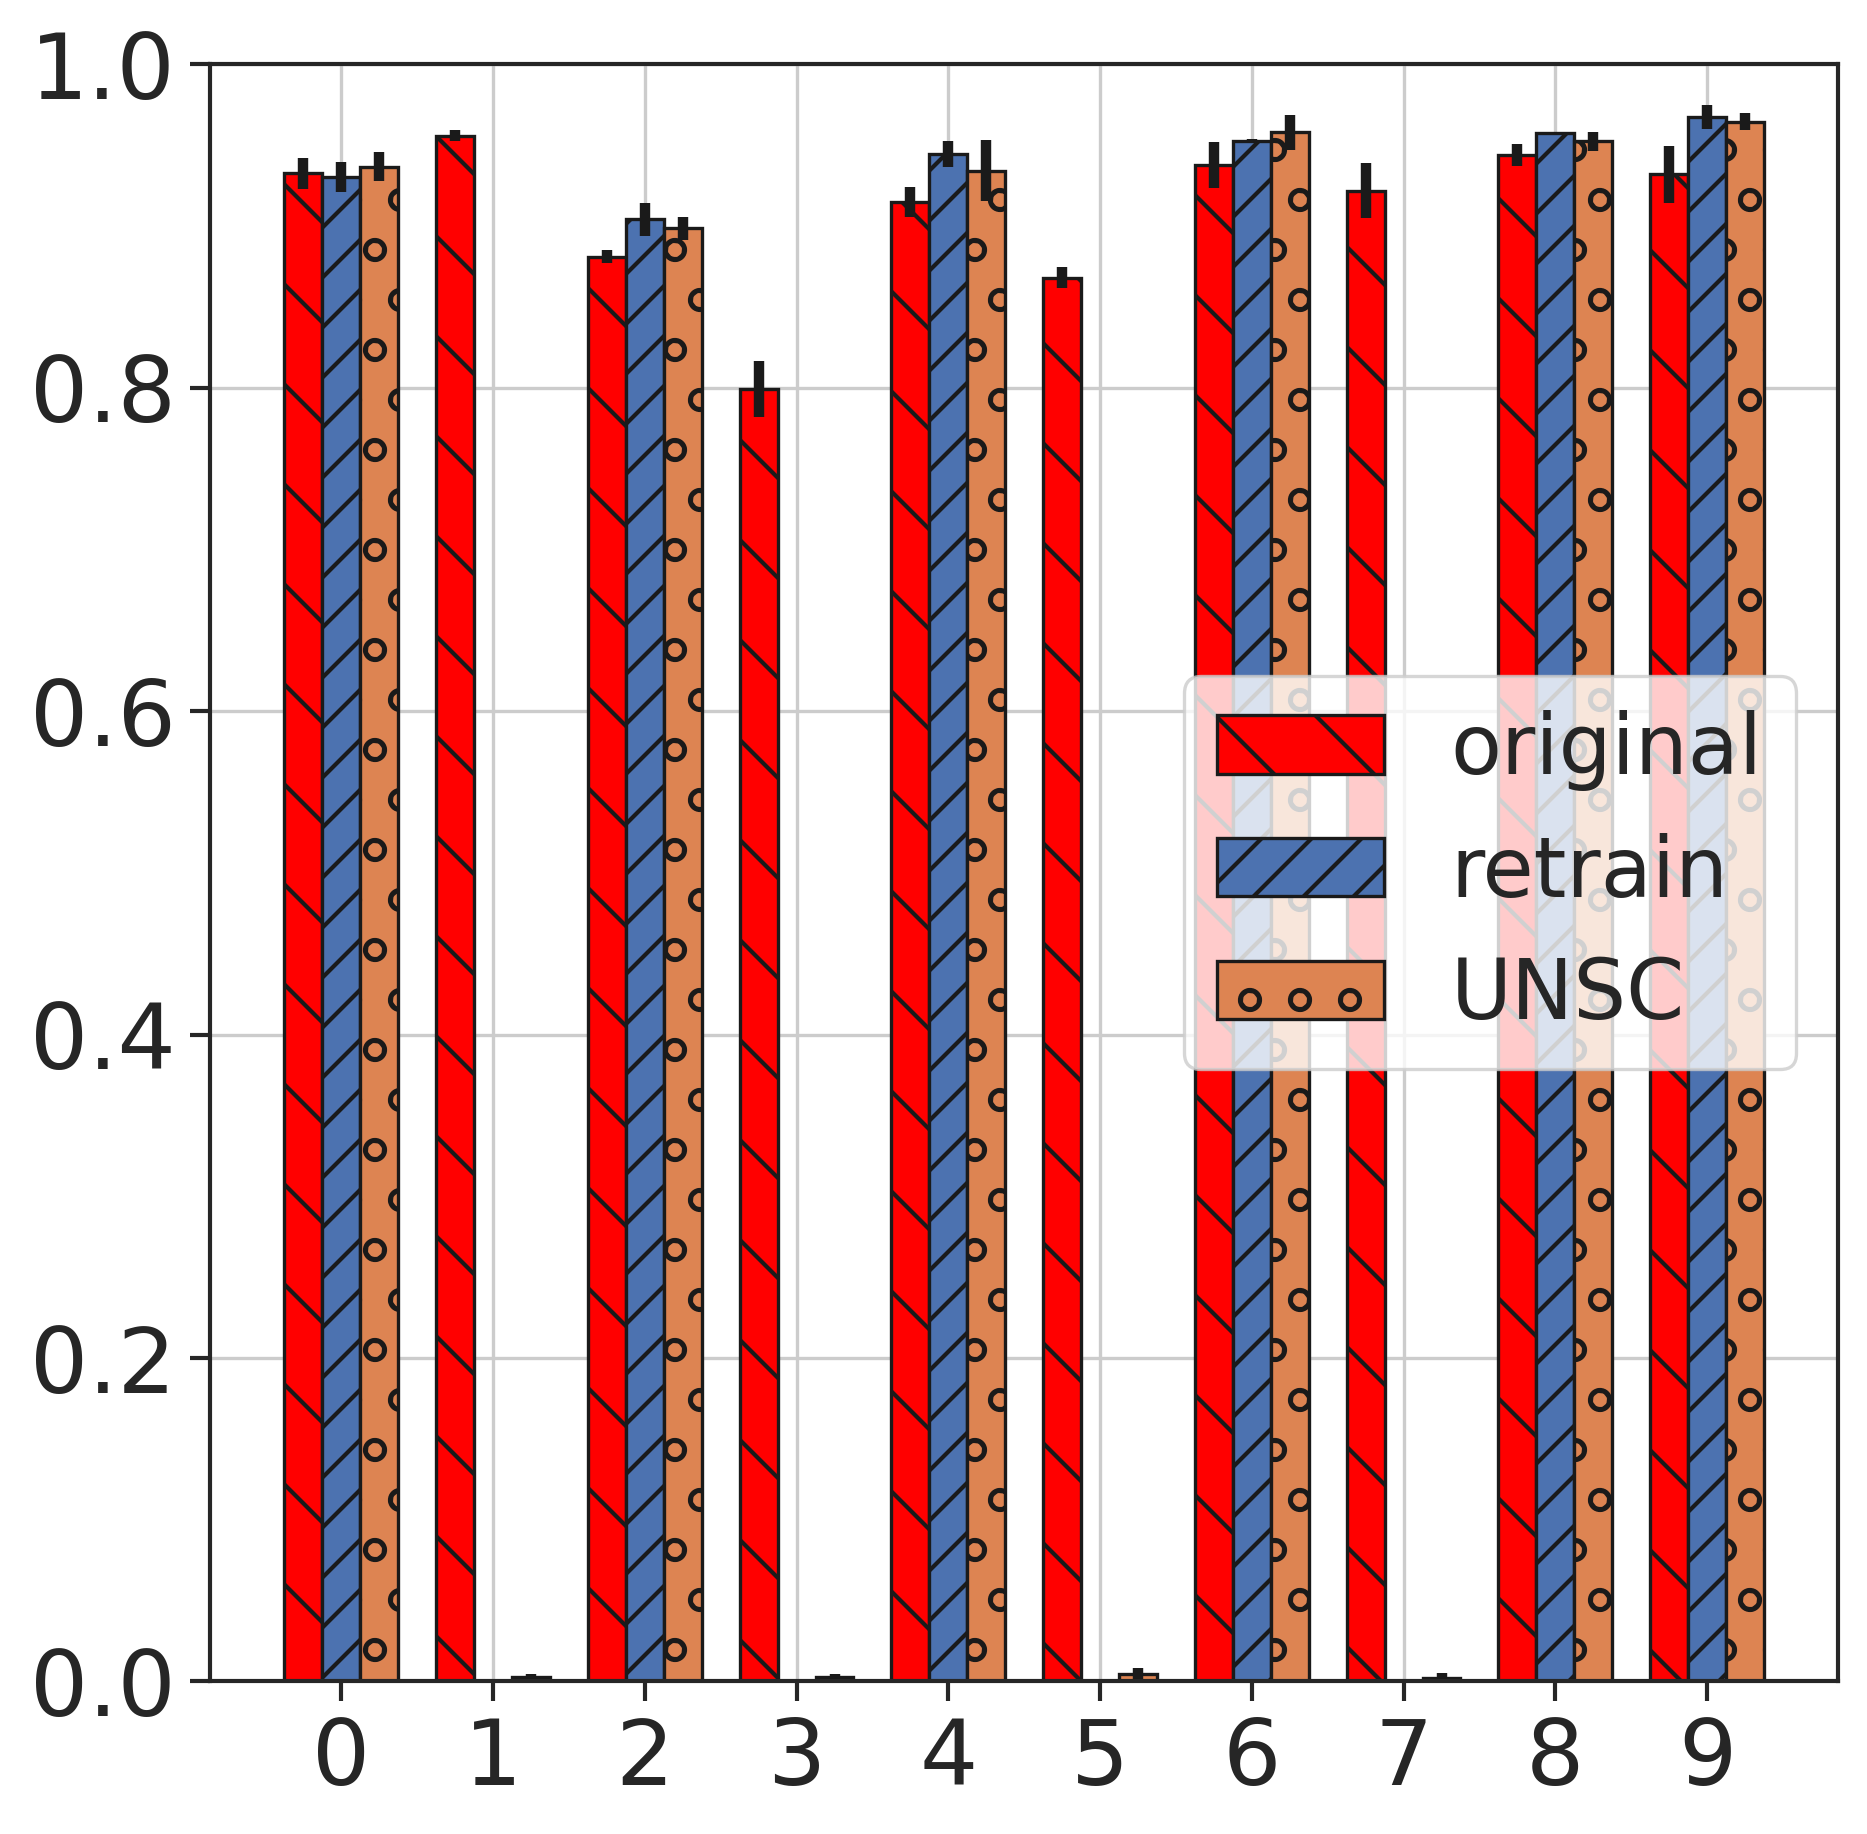

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="ticks")
sns.set_context(
    "paper",
    rc={
        "lines.linewidth": 2.5,
        "xtick.labelsize": 22,
        "ytick.labelsize": 22,
        "lines.markersize": 15,
        "legend.fontsize": 20,
        "axes.labelsize": 22,
        "axes.titlesize": 22,
        "legend.handlelength": 1,
        "legend.handleheight": 1,
    },
)

acc_o = np.array([[0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070],
                [0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420],
                [0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470]])

acc_r = np.array([[0.9430, 0.0000, 0.9100, 0.0000, 0.9560, 0.0000, 0.9540, 0.0000, 0.9560, 0.9680],
                [0.9210, 0.0000, 0.8900, 0.0000, 0.9400, 0.0000, 0.9520, 0.0000, 0.9580, 0.9760],
                [0.9270, 0.0000, 0.9130, 0.0000, 0.9380, 0.0000, 0.9520, 0.0000, 0.9580, 0.9580]])

acc_u = np.array([[0.9330, 0.0040, 0.9010, 0.0020, 0.9610, 0.0050, 0.9490, 0.0010, 0.9560, 0.9620],
                [0.9490, 0.0000, 0.8890, 0.0010, 0.9220, 0.0000, 0.9730, 0.0000, 0.9440, 0.9600],
                [0.9280, 0.0040, 0.9060, 0.0050, 0.9200, 0.0090, 0.9520, 0.0060, 0.9570, 0.9720]])

plt.figure(figsize=(7, 7), dpi=300)

mean_o = acc_o.mean(axis=0)
std_o = acc_o.std(axis=0)
mean_u = acc_u.mean(axis=0)
std_u = acc_u.std(axis=0)
mean_r = acc_r.mean(axis=0)
std_r = acc_r.std(axis=0)
x = np.arange(10)
width = 0.25

rects_o = plt.bar(x - width, mean_o, width, yerr=std_o, edgecolor='k', hatch='\\', color = 'red',label='original')
rects_r = plt.bar(x , mean_r, width, yerr=std_r, hatch='//', edgecolor='k', label='retrain')
rects_u = plt.bar(x + width, mean_u, width, yerr=std_u, hatch='o', edgecolor='k',label=r'UNSC')

plt.gca().set_xticks(x)
plt.grid()
plt.gca().set_ylim([0, 1.0])
plt.legend(loc='center right')
plt.show()



# Unlearn 5 classes

In [78]:
arxiv_name = dict[5]['arxiv_name']
args.unlearn_class = dict[5]['unlean_class']
Acc_r, Acc_f = np.zeros((2,3)), np.zeros((2,3))
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/original_model_12-20-02-15_{args.seeds[i]}.pth'))
    Acc_f[0][i], Acc_r[0][i] = test_by_class(model, test_loader, i=args.unlearn_class)

print('------------ Retrained model ------------')
for i in range(3):
    model_r = get_model(args)
    try:
        model_r.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/retrain_model_{arxiv_name}_{args.seeds[i]}.pth'))
        Acc_f[1][i], Acc_r[1][i] = test_by_class(model_r, test_loader, i=args.unlearn_class)
    except:
        print('No retrained model')
        break

print(f'Original model Acc_f: {100*Acc_f[0].mean():.2f} \pm {100*Acc_f[0].std():.2f}')
print(f'Original model Acc_r: {100*Acc_r[0].mean():.2f} \pm {100*Acc_r[0].std():.2f}')

print(f'Retrained model Acc_f: {100*Acc_f[1].mean():.2f} \pm {100*Acc_f[1].std():.2f}')
print(f'Retrained model Acc_r: {100*Acc_r[1].mean():.2f} \pm {100*Acc_r[1].std():.2f}')

arxiv_name = 'original_model_12-20-02-15'

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.8796, Acc_r: 0.9318
0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420, Acc_f: 0.8928, Acc_r: 0.9284
0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470, Acc_f: 0.8834, Acc_r: 0.9368
------------ Retrained model ------------
0.9450, 0.0000, 0.0000, 0.0000, 0.9620, 0.0000, 0.9620, 0.0000, 0.9610, 0.9660, Acc_f: 0.0000, Acc_r: 0.9592
0.9530, 0.0000, 0.0000, 0.0000, 0.9710, 0.0000, 0.9640, 0.0000, 0.9520, 0.9810, Acc_f: 0.0000, Acc_r: 0.9642
0.9550, 0.0000, 0.0000, 0.0000, 0.9600, 0.0000, 0.9650, 0.0000, 0.9580, 0.9630, Acc_f: 0.0000, Acc_r: 0.9602
Original model Acc_f: 88.53 \pm 0.55
Original model Acc_r: 93.23 \pm 0.34
Retrained model Acc_f: 0.00 \pm 0.00
Retrained model Acc_r: 96.12 \pm 0.22


In [79]:
unlearn_indices = np.where(np.isin(train_targets_list, args.unlearn_class))[0]

# conver to the original indices
unlearn_indices = train_loader.sampler.indices[unlearn_indices]

unlearn_sampler = torch.utils.data.SubsetRandomSampler(unlearn_indices)
unlearn_subset_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                                    batch_size=args.batch_size, 
                                                    sampler=unlearn_sampler)
remain_class = np.setdiff1d(np.arange(args.num_classes), args.unlearn_class)

remain_indices = np.where(~np.isin(train_targets_list, args.unlearn_class))[0]
remain_indices = train_loader.sampler.indices[remain_indices]

remain_sampler = torch.utils.data.SubsetRandomSampler(remain_indices)
remain_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                            batch_size=args.batch_size, 
                                            sampler=remain_sampler)

Proj_mat_lst =[]
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    print(f'------------ Trail {i} ------------')
    merged_feat_mat = []
    for cls_id in range(10): 
        cls_indices = np.where(np.isin(train_targets_list, cls_id))[0]
        cls_indices = train_loader.sampler.indices[cls_indices]
        cls_sampler = torch.utils.data.SubsetRandomSampler(cls_indices)
        cls_loader_dict = torch.utils.data.DataLoader(train_loader.dataset, 
                                                                batch_size=args.batch_size, 
                                                                sampler=cls_sampler)
        if cls_id in args.unlearn_class:
            continue
        for batch, (x, y) in enumerate(cls_loader_dict ):
            x = x.cuda()
            y = y.cuda()
            mat_list = get_representation_matrix(model, 
                                                x, 
                                                batch_list=[24, 100, 100, 125, 125, 250, 250, 256, 256])
            break
        threshold = 0.97 + 0.003*cls_id
        merged_feat_mat = update_GPM(mat_list, threshold, merged_feat_mat)
        proj_mat = [torch.Tensor(np.dot(layer_basis, layer_basis.transpose())) for layer_basis in merged_feat_mat]
        Proj_mat_lst.append(proj_mat)


------------ Trail 0 ------------
Threshold:  0.97
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 5/27
Layer 2 : 48/432
Layer 3 : 180/432
Layer 4 : 552/864
Layer 5 : 618/864
Layer 6 : 617/864
Layer 7 : 666/864
Layer 8 : 76/96
Layer 9 : 4/96
----------------------------------------
Threshold:  0.982
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 8/27
Layer 2 : 70/432
Layer 3 : 240/432
Layer 4 : 700/864
Layer 5 : 733/864
Layer 6 : 716/864
Layer 7 : 779/864
Layer 8 : 90/96
Layer 9 : 8/96
----------------------------------------
Threshold:  0.988
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 11/27
Layer 2 : 107/432
Layer 3 : 288/432
Layer 4 : 758/864
Layer 5 : 779/864
Layer 6 : 761/864
Layer 7 : 809/864
Layer 8 : 93/96
Layer 9 : 10/96
------------------------------------

In [83]:
def get_pseudo_label(args, model, x):
    masked_output = model(x)
    masked_output[:, args.unlearn_class] = -np.inf
    pseudo_labels = torch.topk(masked_output, k=1, dim=1).indices
    return pseudo_labels.reshape(-1)

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.04)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    model.eval()
    for ep in range(25):
        for batch, (x, y) in enumerate(unlearn_subset_loader):
            x = x.cuda()
            y = get_pseudo_label(args, model, x)
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            kk = 0 
            for k, (m,params) in enumerate(sgd_mr_model.named_parameters()):
                if len(params.size())!=1:
                    sz =  params.grad.data.size(0)
                    params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                            Proj_mat_lst[i][kk].cuda()).view(params.size())
                    kk +=1
                elif len(params.size())==1:
                    params.grad.data.fill_(0)
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070, Acc_f: 0.8796, Acc_r: 0.9318
[train] epoch 0, batch 43, loss 1.216407299041748
0.8700, 0.2700, 0.2570, 0.0780, 0.9180, 0.0200, 0.9700, 0.0490, 0.9660, 0.9230, Acc_f: 0.1348, Acc_r: 0.9294
[train] epoch 1, batch 43, loss 0.9499720931053162
0.9100, 0.1340, 0.1460, 0.0580, 0.9240, 0.0210, 0.9750, 0.0210, 0.9620, 0.9420, Acc_f: 0.0760, Acc_r: 0.9426
[train] epoch 2, batch 43, loss 0.6702789664268494
0.9290, 0.0680, 0.1140, 0.0500, 0.9270, 0.0210, 0.9790, 0.0160, 0.9580, 0.9430, Acc_f: 0.0538, Acc_r: 0.9472
[train] epoch 3, batch 43, loss 0.6160269379615784
0.9430, 0.0490, 0.0950, 0.0400, 0.9310, 0.0210, 0.9790, 0.0130, 0.9500, 0.9430, Acc_f: 0.0436, Acc_r: 0.9492
[train] epoch 4, batch 43, loss 0.56300950050354
0.9500, 0.0360, 0.0800, 0.0320, 0.9220, 0.0180, 0.9810, 0.0130, 0.9500, 0.9480, Acc_f: 0.0358, Acc_r: 0.9502
[train] epoch 5, batch 43, loss 0.4867788255214691
0.9540, 0.0260, 0.0740, 0.0260, 0.9290, 0.0

In [ ]:
Acc_r = 100*np.array([0.9600, 0.9632, 0.9614])
Acc_f = 100*np.array([0.0012, 0.0054, 0.0138])

print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

In [7]:
a = (100*np.array([0.9600, 0.9632, 0.9614])-100*np.array([0.9318, 0.9284, 0.9368]))
a.mean(), a.std()

(2.9200000000000017, 0.4223742416388495)

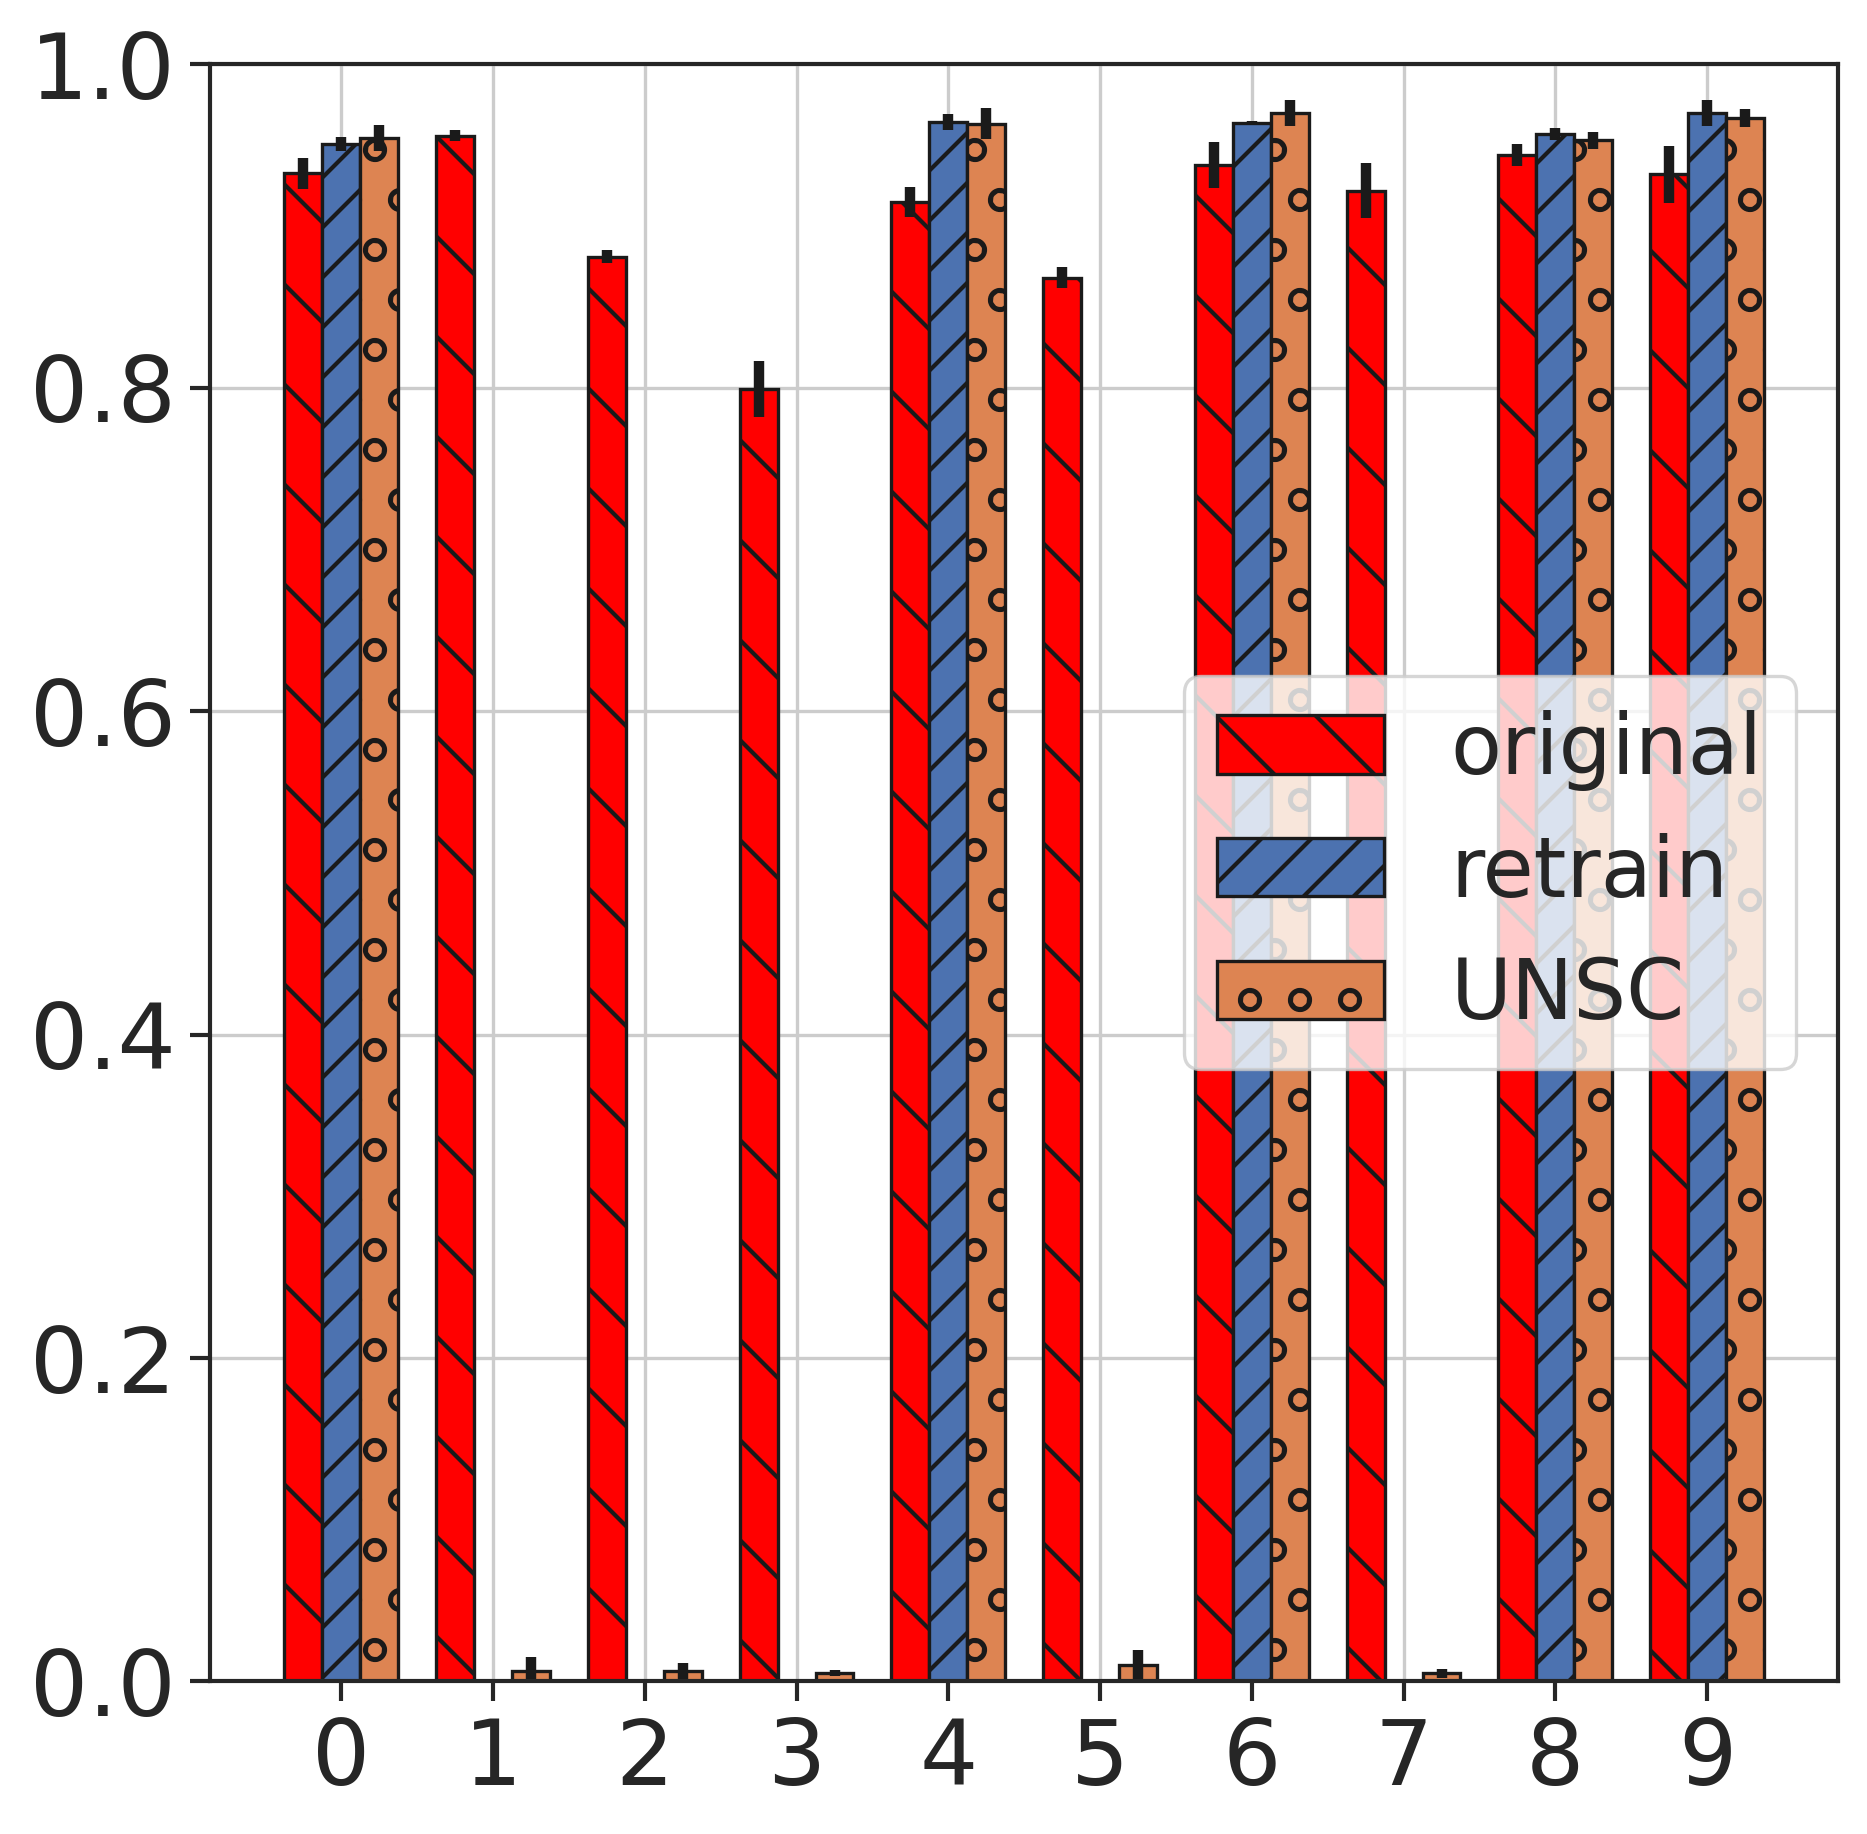

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="ticks")
sns.set_context(
    "paper",
    rc={
        "lines.linewidth": 2.5,
        "xtick.labelsize": 22,
        "ytick.labelsize": 22,
        "lines.markersize": 15,
        "legend.fontsize": 20,
        "axes.labelsize": 22,
        "axes.titlesize": 22,
        "legend.handlelength": 1,
        "legend.handleheight": 1,
    },
)

acc_o = np.array([[0.9460, 0.9610, 0.8810, 0.7980, 0.9060, 0.8590, 0.9580, 0.8990, 0.9420, 0.9070],
                [0.9250, 0.9540, 0.8760, 0.8210, 0.9110, 0.8740, 0.9270, 0.9390, 0.9370, 0.9420],
                [0.9270, 0.9530, 0.8860, 0.7790, 0.9280, 0.8710, 0.9290, 0.9280, 0.9530, 0.9470]])

acc_r = np.array([[0.9450, 0.0000, 0.0000, 0.0000, 0.9620, 0.0000, 0.9620, 0.0000, 0.9610, 0.9660],
                [0.9530, 0.0000, 0.0000, 0.0000, 0.9710, 0.0000, 0.9640, 0.0000, 0.9520, 0.9810],
                [0.9550, 0.0000, 0.0000, 0.0000, 0.9600, 0.0000, 0.9650, 0.0000, 0.9580, 0.9630]])

acc_u = np.array([[0.9630, 0.0000, 0.0010, 0.0040, 0.9510, 0.0000, 0.9790, 0.0010, 0.9480, 0.9590],
                [0.9570, 0.0010, 0.0060, 0.0040, 0.9650, 0.0090, 0.9710, 0.0070, 0.9510, 0.9720],
                [0.9440, 0.0190, 0.0130, 0.0080, 0.9740, 0.0220, 0.9600, 0.0070, 0.9600, 0.9690]])

plt.figure(figsize=(7, 7), dpi=300)

mean_o = acc_o.mean(axis=0)
std_o = acc_o.std(axis=0)
mean_u = acc_u.mean(axis=0)
std_u = acc_u.std(axis=0)
mean_r = acc_r.mean(axis=0)
std_r = acc_r.std(axis=0)
x = np.arange(10)
width = 0.25

rects_o = plt.bar(x - width, mean_o, width, yerr=std_o, edgecolor='k', hatch='\\', color = 'red',label='original')
rects_r = plt.bar(x , mean_r, width, yerr=std_r, hatch='//', edgecolor='k', label='retrain')
rects_u = plt.bar(x + width, mean_u, width, yerr=std_u, hatch='o', edgecolor='k',label=r'UNSC')
plt.gca().set_xticks(x)
plt.grid()
plt.gca().set_ylim([0, 1.0])
plt.legend(loc='center right')

plt.show()

